# Introduction to Python  

## Natural Language Processing - Exploratory Data Analysis (EDA)

In [1]:
!pip install -U -q nltk gensim wordcloud textract textstat textblob spacy pyldavis goose3

In [2]:
import os
import pathlib
import time
import codecs
import string
import re
from collections import Counter
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import urllib
import requests
from bs4 import BeautifulSoup

import nltk
import networkx as nx
import gensim
from wordcloud import WordCloud
import textract
import pyLDAvis
import pyLDAvis.gensim
import spacy
import textstat
import textblob

from IPython.core.display import Image
%matplotlib inline

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package brown to /home/jovyan/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

Specifying the path to the files

In [4]:
datapath = "../Data/"
outputs = "../Data/"

Examining files and folders

In [5]:
onlydirs = [f for f in os.listdir(datapath) if os.path.isdir(os.path.join(datapath,f)) and not f.startswith('.')]
onlydirs

['EDA', 'Oplexicon_v3.0', 'Texts', 'names']

In [6]:
corpuspath = os.path.join(datapath, 'Texts')
onlyfiles = [f for f in os.listdir(corpuspath) if os.path.isfile(os.path.join(corpuspath,f)) and not f.startswith('.')]
onlydirs.sort()

print('Files in the folder:')
for i, w in enumerate(onlyfiles[0:]):
    print(i+1, '--' ,w)

Files in the folder:
1 -- ARTIGOS-RBE-COM-RESUMO.xlsx
2 -- AldousHuxley_bravenewworld.pdf
3 -- MarcelProust_EmBuscadoTempoPerdido.pdf
4 -- RobertFrost_Poetry.pdf


## Example 1

Loading first corpus:

In [7]:
df = pd.read_excel(os.path.join(corpuspath, 'ARTIGOS-RBE-COM-RESUMO.xlsx'))
df.head()

,N,Revista,Título do artigo,Resumo,Volume,Número,Ano,Autores,Nº de Autores,URL
0,1,Revista Brasileira de Economia,Miséria ou Abundância: Alguns Modelos de Cresc...,NaN,20,1,1966,"Kingston, Lúcia Silva",1,http://bibliotecadigital.fgv.br/ojs/index.php/...
1,2,Revista Brasileira de Economia,Comentário sobre o Modelo Econométrico de Tint...,NaN,25,1,1971,"Fioravante, Moacyr;Naylor, Thomas H.;Monteiro,...",3,http://bibliotecadigital.fgv.br/ojs/index.php/...
2,3,Revista Brasileira de Economia,Modernização e desigualdade na agricultura bra...,NaN,43,2,1989,"Hoffmann, Rodolfo;Kassouf, Ana Lúcia",2,http://bibliotecadigital.fgv.br/ojs/index.php/...
3,4,Revista Brasileira de Economia,Optimal Insider Strategy with Law Penalties,We study the optimal continuous trading strate...,70,1,2016,"Fajardo, Jose",1,http://bibliotecadigital.fgv.br/ojs/index.php/...
4,5,Revista Brasileira de Economia,Demands for Short-Run Assets and Liabilities i...,NaN,60,1,2006,"Silva, Evandro;Resende, Marcelo",2,http://bibliotecadigital.fgv.br/ojs/index.php/...


In [8]:
df.columns

Index(['N', 'Revista', 'Título do artigo', 'Resumo', 'Volume', 'Número', 'Ano',
       'Autores', 'Nº de Autores', 'URL'],
      dtype='object')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 10 columns):
N                   1556 non-null int64
Revista             1556 non-null object
Título do artigo    1556 non-null object
Resumo              330 non-null object
Volume              1556 non-null int64
Número              1556 non-null object
Ano                 1556 non-null int64
Autores             1556 non-null object
Nº de Autores       1556 non-null int64
URL                 1556 non-null object
dtypes: int64(4), object(6)
memory usage: 121.7+ KB


In [10]:
df['text'] = df['Título do artigo'] + " "

In [11]:
texts = df['text'].sum()
texts[0:1000]

'Miséria ou Abundância: Alguns Modelos de Crescimento para Economias Subdesenvolvidas Comentário sobre o Modelo Econométrico de Tinther, para o Brasil Modernização e desigualdade na agricultura brasileira Optimal Insider Strategy with Law Penalties Demands for Short-Run Assets and Liabilities in Brazil: a Portfolio Approach Alguns Reparos sobre a Teoria do Multiplicador INTRODUÇÃO: ORIGENS HISTÓRICAS DO SUBDESENVOLVIMENTO CONTEMPORÂNEO Princípios para a reformulação da política comercial brasileira A reforma da economia socialista: lições dos primeiros três anos Intensidades fatoriais na economia brasileira: novo teste empírico do teorema de Heckscher-Ohlin Algumas Considerações sobre as Fases do Desenvolvimento Econõmico Poupança e crescimento econômico Padrões de Convergência e Divergência do Crescimento Econômico Regional e das Migrações no Brasil - 1940-1960 Octavio Gouveia de Bulhões - Orientação e Controle da Economia The Economic Theory of Regulation: the Case of Agrarian Reform

In [12]:
stop_pt = nltk.corpus.stopwords.words('portuguese')
stop_en = nltk.corpus.stopwords.words('english')

In [13]:
stopwords = stop_en + stop_pt
stopwords.extend(['-','', '”','sobre'])

In [14]:
list_words = texts.split()
list_words = [l.strip().lower() for l in list_words]
list_words = [l.strip(string.punctuation) for l in list_words]
list_words = [l for l in list_words if l not in stopwords]
list_words[0:20]

['miséria',
 'abundância',
 'alguns',
 'modelos',
 'crescimento',
 'economias',
 'subdesenvolvidas',
 'comentário',
 'modelo',
 'econométrico',
 'tinther',
 'brasil',
 'modernização',
 'desigualdade',
 'agricultura',
 'brasileira',
 'optimal',
 'insider',
 'strategy',
 'law']

In [15]:
freqdist = Counter(list_words)

In [16]:
freqdist.most_common(20)

[('brasil', 271),
 ('brasileira', 96),
 ('desenvolvimento', 96),
 ('política', 87),
 ('economia', 87),
 ('econômico', 85),
 ('análise', 82),
 ('inflação', 74),
 ('brazil', 66),
 ('econômica', 59),
 ('modelo', 53),
 ('renda', 50),
 ('preços', 50),
 ('monetária', 50),
 ('crescimento', 49),
 ('teoria', 48),
 ('brasileiro', 48),
 ('brazilian', 46),
 ('mercado', 44),
 ('caso', 41)]

In [17]:
cleaned = ' '.join(list_words)
wordcloud = WordCloud().generate(cleaned)

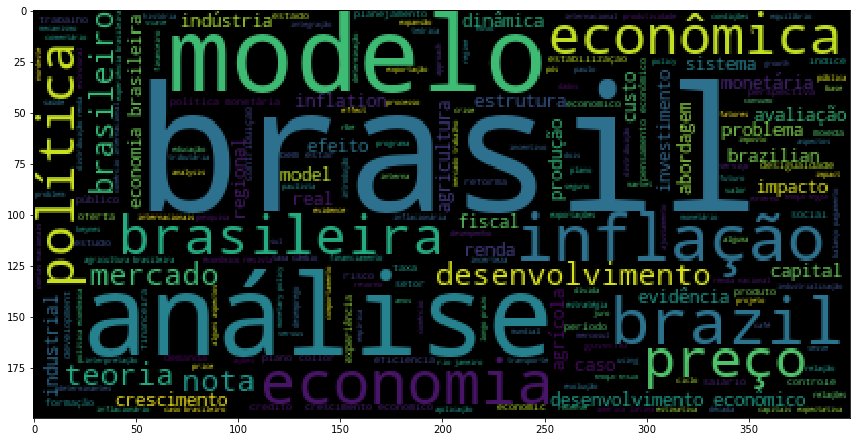

In [18]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.imshow(wordcloud, interpolation='nearest')
plt.tight_layout()

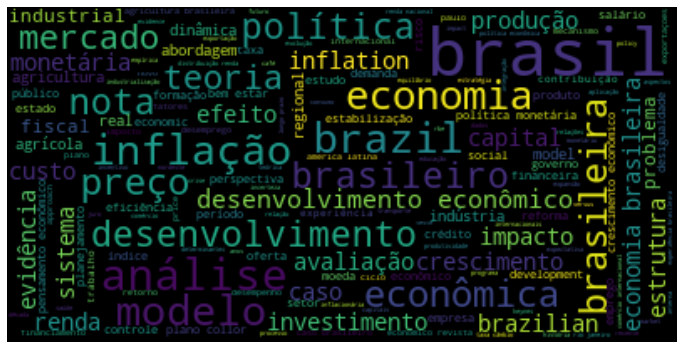

In [19]:
# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(cleaned)
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [20]:
# The pil way (if you don't have matplotlib)
image = wordcloud.to_image()
image.show()

## Example 2

In [21]:
print('Files in the folder:')
for i, w in enumerate(onlyfiles[0:]):
    print(i+1, '--' ,w)

Files in the folder:
1 -- ARTIGOS-RBE-COM-RESUMO.xlsx
2 -- AldousHuxley_bravenewworld.pdf
3 -- MarcelProust_EmBuscadoTempoPerdido.pdf
4 -- RobertFrost_Poetry.pdf


In [22]:
raw_texts = ''

for filename in [f for f in onlyfiles if f.endswith('pdf')]:
    print(filename)
    text = textract.process(os.path.join(corpuspath,filename)).decode('utf-8')
    print('\nTexto:\n', text[0:50])
    raw_texts += '\n'+ text
    break

AldousHuxley_bravenewworld.pdf

Texto:
 Brave New World

Aldous Leonard Huxley

February 6


In [23]:
print(len(raw_texts))

379238


Cleaning and homogenizing texts:

In [24]:
cleaned_texts = raw_texts.lower()
cleaned_texts = re.sub(' +',' ', cleaned_texts) #Remove multiple spaces
cleaned_texts = re.sub(r'\n\s*\n', '\n', cleaned_texts)

In [25]:
print(len(cleaned_texts))

377226


In [26]:
print(cleaned_texts[0:200])


brave new world
aldous leonard huxley
february 6, 2002
contents
one
two
three
four
five
six
5
17
25
41
2 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 45
51
2 . . . . . . . . . . 


In [27]:
list_words = cleaned_texts.split()
list_words = [l.strip().lower() for l in list_words]
list_words = [l.strip(string.punctuation+'“”’') for l in list_words]
list_words = [l for l in list_words if l not in stopwords]

freqdist = Counter(list_words)
freqdist.most_common(20)

[('said', 315),
 ('one', 270),
 ('bernard', 215),
 ('savage', 190),
 ('like', 185),
 ('lenina', 180),
 ('don’t', 119),
 ('little', 113),
 ('made', 112),
 ('time', 109),
 ('voice', 105),
 ('two', 104),
 ('man', 102),
 ('eyes', 101),
 ('round', 100),
 ('linda', 100),
 ('would', 99),
 ('though', 97),
 ('face', 96),
 ('away', 94)]

Finding ocurrences of an expression:

In [28]:
expression = 'life'
pos = 0 
positions = []

while pos != -1:
    position = cleaned_texts.find(expression,pos+1)
    pos = position
    positions.append(position)
positions.pop()
print('The expression is found {} times'.format(len(positions)))
print(positions)

The expression is found 40 times
[5680, 40191, 51625, 53650, 68219, 72538, 78584, 81673, 89945, 110167, 111959, 112554, 116511, 117371, 135659, 143540, 154194, 159245, 163993, 173661, 198820, 204876, 209098, 210597, 212210, 219368, 221494, 224695, 254252, 258084, 276816, 287156, 291418, 312044, 319953, 326880, 329682, 336020, 357585, 367936]


Understanding contexts in which words occur:

In [29]:
# Pure Python
window = 18
for position in positions[0:20]:
    print(cleaned_texts[position - window:position + window + len(expression)].strip())

will bud, will proliferate, will divide.
mind too-all his life long. the mind th
of tightly
packed life, reeking with emo
ngers of fam-
ily life. the world was fu
ht hundred simple lifers were mowed down
hroughout a whole lifetime.”
“. two roun
have got through life without ever touc
th fore-shortened life. forests of
centr
suffered all his life from the consciou
e end,
our larger life has but begun.”
a
g with a
galvanic life. the president re
th
an independent life. “ford!” they wer
, but of balanced life, of energies at
r
ever been in his life before. he
had em
t stimulating and
life-giving threat. wa
feel larger than life. but that,
as he
o indecent in her life.
and what made it
stopped beating, life seemed to have co
ﬁrst time in his life, the face of a gi
rything. all your life.”
“but what is th


In [30]:
# Using NLTK

tknzr = nltk.tokenize.WordPunctTokenizer()
tokens = tknzr.tokenize(cleaned_texts)
nltk_text = nltk.Text(tokens)

nltk_text.concordance(expression.lower(), width=120, lines=20)

Displaying 20 of 36 matches:
he child ’ s mind only . the adult ’ s mind too - all his life long . the mind that judges and desires and decides - mad
ole , a midden , hot with the frictions of tightly packed life , reeking with emotion . what suffocating intimacies , wh
een the ﬁrst to reveal the appalling dangers of fam - ily life . the world was full of fathers - was therefore full of m
tured . people said of him that he could have got through life without ever touching soma . the malice and bad tempers f
 sub - urbs . the green was maggoty with fore - shortened life . forests of centrifugal bumble - puppy towers gleamed be
 the physi - cally defective bernard had suffered all his life from the conscious - ness of being separate , it was only
 in - one ! we long to die , for when we end , our larger life has but begun .” again twelve stanzas . by this time the 
tched expectancy , quivering and creeping with a galvanic life . the president reached out his hand ; and suddenly a voi
eem

Words that occur in similar contexts than the query expression:

In [31]:
nltk_text.similar(expression)

course voice head bed face ears room hands mouth arms biology eyes
tone father mother side feet knees cheek neck


[Collocations](http://en.wikipedia.org/wiki/Collocation) are expressions of multiple words which commonly co-occur.  
http://www.nltk.org/howto/collocations.html  

In [32]:
nltk_text.collocation_list(num=20, window_size=20)

[('mustapha', 'mond'),
 ('whisk', 'whisk'),
 ('arch', 'songster'),
 ('want', 'want'),
 ('shook', 'head'),
 ('orgy', 'porgy'),
 ('every', 'one'),
 ('forty', 'seven'),
 ('dearest', 'dearest'),
 ('bye', 'dearest'),
 ('zip', 'zip'),
 ('east', 'south'),
 ('forty', 'forty'),
 ('ending', 'better'),
 ('south', 'south'),
 ('community', 'songster'),
 ('arch', 'community'),
 ('young', 'man'),
 ('stability', 'stability'),
 ('impudent', 'strumpet')]

Below we are using [Pointwise Mutual Information](http://en.wikipedia.org/wiki/Pointwise_mutual_information).

In [33]:
max_items = 30
freq_min_b = 10
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder2 = nltk.collocations.BigramCollocationFinder.from_words(nltk_text)
finder2.apply_word_filter(lambda w: w in string.punctuation)
finder2.apply_freq_filter(freq_min_b)
for a, b in finder2.nbest(bigram_measures.pmi, max_items):
    print(a, b)

o brave
mustapha mond
synthetic music
brave new
helmholtz watson
greater being
henry foster
ve got
sat down
better than
new world
young man
an hour
our ford
bernard marx
stepped out
an epsilon
too much
as though
once more
is better
more than
i suppose
must have
so much
old man
?” asked
far as
at least
at last


In [34]:
for a, b in (finder2.above_score(bigram_measures.raw_freq, 50.0 / len(list(nltk.bigrams(tokens))))):
        print(a, b)

’ s
of the
’ t
.” “
in the
“ i
on the
to the
,” he
the savage
,” said
at the
it was
i ’
in a
and the
don ’
to be
he was
“ but
he had
with a
all the
’ re
was a
into the
there was
it ’
with the
.” he
the director
from the
out of
.” the
of a
of his
as though
you ’
he said
said the
’ m
?” “
“ and
,” she
“ you
by the
for the
they ’
for a
of course
they were
’ ve
in his
one of
“ what


In [35]:
max_items = 30
freq_min_t = 6
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder3 = nltk.collocations.TrigramCollocationFinder.from_words(nltk_text)
finder3.apply_word_filter(lambda w: w in string.punctuation)
finder3.apply_ngram_filter(lambda w1, w2, w3:  w1 in ['da', 'de', 'das'])
finder3.apply_freq_filter(freq_min_t)
for a, b, c in finder3.nbest(trigram_measures.pmi, max_items):
    print(a, b, c)

o brave new
brave new world
better than mending
ending is better
.” .. ...
shrugged his shoulders
.. ... “
half an hour
said mustapha mond
“ o brave
years ’ war
the assistant predestinator
the deputy sub
is better than
every one else
shook his head
belongs to every
nine years ’
a few seconds
shook her head
hundred and ﬁfty
so far as
’ ve got
boys and girls
a few minutes
beside the bed
in another tone
he picked up
half a gramme
the nine years


In [36]:
for a, b, c in finder3.above_score(trigram_measures.raw_freq,50.0 / len(list(nltk.trigrams(tokens)))):
        print (a, b, c)

don ’ t
it ’ s
i ’ m
,” said the
,” he said


In [37]:
from nltk.util import ngrams
n = 4
xgrams = ngrams(tokens, n)
xgrams_counter = Counter(xgrams)
xgrams_counter.most_common(20)

[(('.', '.', '.', '.'), 116),
 (('i', 'don', '’', 't'), 32),
 (('.', '“', 'oh', ','), 28),
 (('the', 'd', '.', 'h'), 26),
 (('d', '.', 'h', '.'), 26),
 (('.', 'h', '.', 'c'), 26),
 (('don', '’', 't', 'you'), 25),
 (('h', '.', 'c', '.'), 24),
 ((',”', 'he', 'said', ','), 23),
 (('“', 'it', '’', 's'), 22),
 (('don', '’', 't', 'know'), 20),
 (('“', 'i', '’', 'm'), 20),
 (('.', 'it', '’', 's'), 20),
 ((',', '“', 'i', '’'), 19),
 (('.', 'there', 'was', 'a'), 19),
 (('you', 'can', '’', 't'), 18),
 ((',', 'of', 'course', ','), 17),
 (('shook', 'his', 'head', '.'), 16),
 (('“', 'i', 'don', '’'), 16),
 (('.', '“', 'i', '’'), 16)]

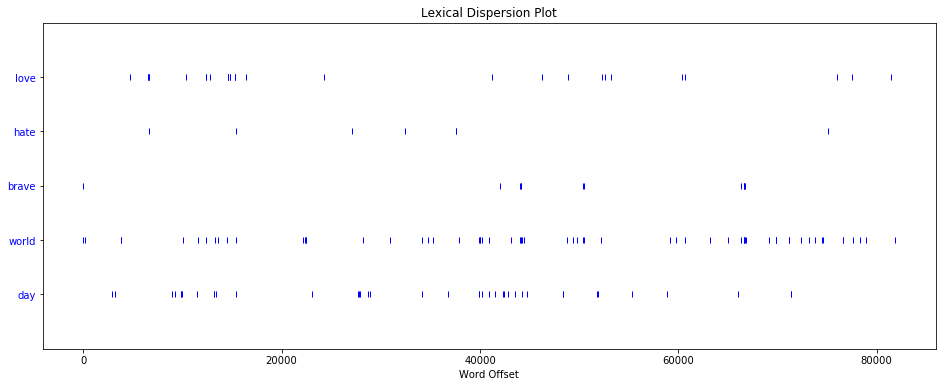

In [38]:
dispersion_words = ['love', 'hate', 'brave','world', 'day']
plt.figure(figsize=(16,6))
nltk_text.dispersion_plot(dispersion_words)

Different ways to visualize frequent words:

In [39]:
freqdist.most_common(100)

[('said', 315),
 ('one', 270),
 ('bernard', 215),
 ('savage', 190),
 ('like', 185),
 ('lenina', 180),
 ('don’t', 119),
 ('little', 113),
 ('made', 112),
 ('time', 109),
 ('voice', 105),
 ('two', 104),
 ('man', 102),
 ('eyes', 101),
 ('round', 100),
 ('linda', 100),
 ('would', 99),
 ('though', 97),
 ('face', 96),
 ('away', 94),
 ('still', 93),
 ('room', 92),
 ('went', 92),
 ('back', 91),
 ('know', 89),
 ('well', 89),
 ('it’s', 84),
 ('every', 82),
 ('old', 82),
 ('director', 81),
 ('could', 81),
 ('even', 80),
 ('suddenly', 77),
 ('head', 76),
 ('came', 76),
 ('course', 75),
 ('men', 75),
 ('hand', 75),
 ('helmholtz', 75),
 ('go', 74),
 ('oh', 72),
 ('three', 71),
 ('young', 71),
 ('say', 71),
 ('come', 71),
 ('words', 68),
 ('long', 68),
 ('door', 68),
 ('see', 68),
 ('good', 67),
 ('make', 67),
 ('another', 67),
 ('ﬁrst', 67),
 ('began', 67),
 ('i’m', 67),
 ('asked', 67),
 ('looked', 66),
 ('world', 64),
 ('something', 64),
 ('think', 63),
 ('soma', 63),
 ('got', 62),
 ('much', 61),
 

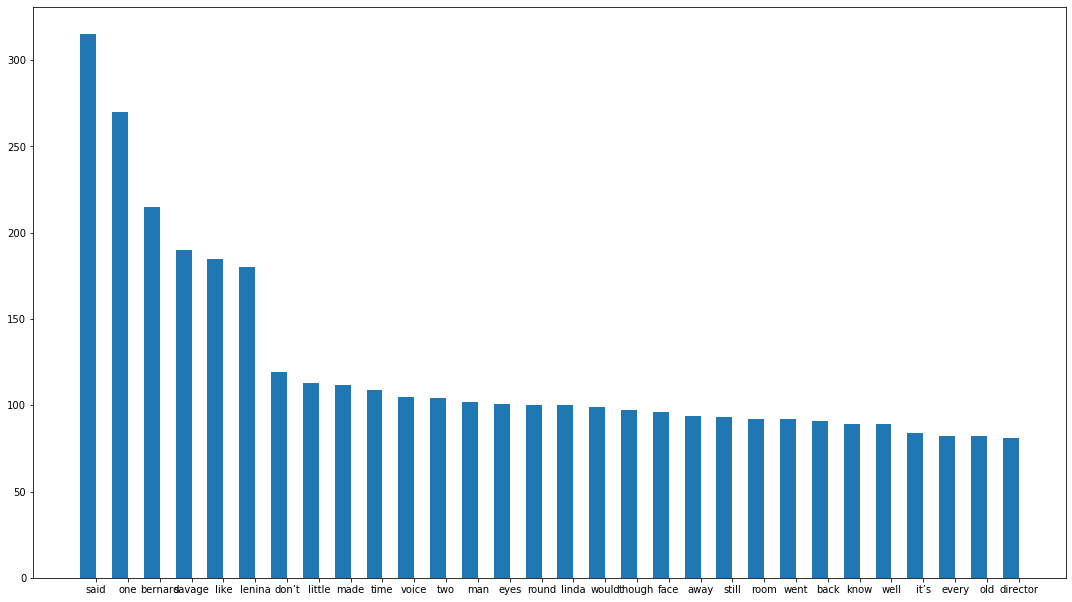

In [40]:
labels, values = zip(*freqdist.most_common(30))

indexes = np.arange(len(labels))
width = 0.5

plt.bar(indexes, values, width)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

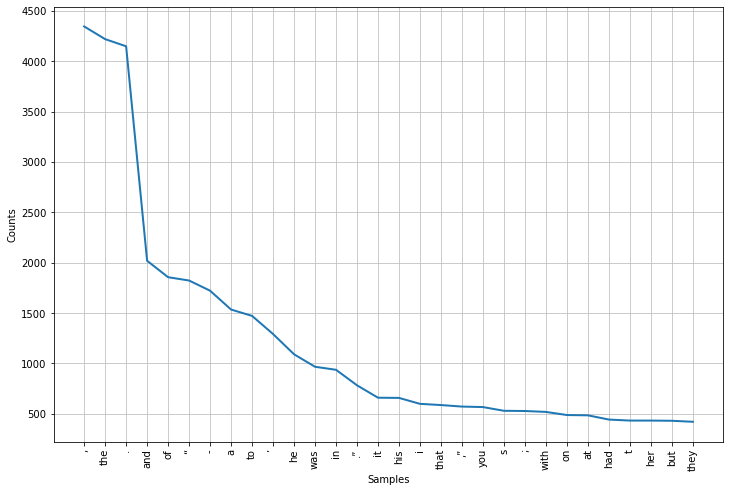

In [41]:
fd_words = nltk.FreqDist(tokens)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,8)) 
fd_words.plot(30)

Cumulative distribution of frequencies:

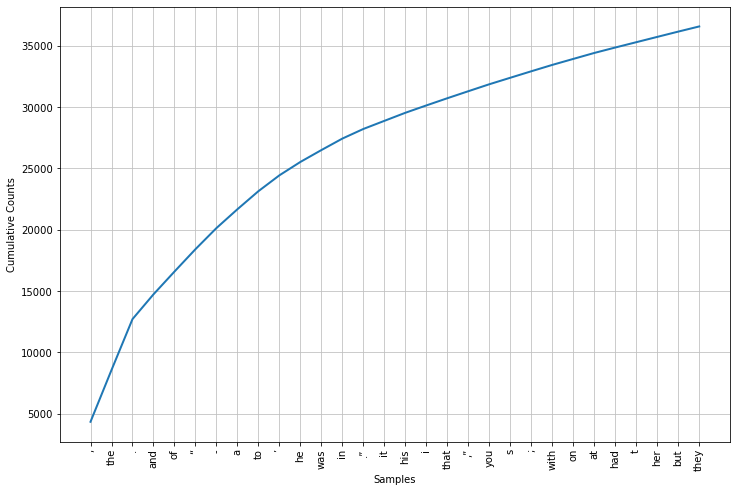

In [42]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,8)) 
fd_words.plot(30, cumulative = True)

Automated abstracts (not comparable to human made abstracts)

In [43]:
def score_sentences(sentences, important_words):
    # Approach taken from "The Automatic Creation of Literature Abstracts" by H.P. Luhn
    CLUSTER_THRESHOLD = 5  # Distance between words to consider
    scores = []
    sentence_idx = -1
    #for s in [nltk.tokenize.word_tokenize(s) for s in sentences]:
    punktw2 = nltk.tokenize.WordPunctTokenizer() #trocando pelo punkt (melhor?)
    for s in [punktw2.tokenize(s) for s in sentences]:    
        sentence_idx += 1
        word_idx = []
        # For each word in the word list...
        for w in important_words:
            try:
                # Compute an index for where any important words occur in the sentence
                word_idx.append(s.index(w))
            except ValueError as e: # w not in this particular sentence
                pass
        word_idx.sort()
        # It is possible that some sentences may not contain any important words at all
        if len(word_idx)== 0: continue
        # Using the word index, compute clusters by using a max distance threshold
        # for any two consecutive words
        clusters = []
        cluster = [word_idx[0]]
        i = 1
        while i < len(word_idx):
            if word_idx[i] - word_idx[i - 1] < CLUSTER_THRESHOLD:
                cluster.append(word_idx[i])
            else:
                clusters.append(cluster[:])
                cluster = [word_idx[i]]
            i += 1
        clusters.append(cluster)
        # Score each cluster. The max score for any given cluster is the score 
        # for the sentence
        max_cluster_score = 0
        for c in clusters:
            significant_words_in_cluster = len(c)
            total_words_in_cluster = c[-1] - c[0] + 1
            score = 1.0 * significant_words_in_cluster \
                * significant_words_in_cluster / total_words_in_cluster
            if score > max_cluster_score:
                max_cluster_score = score
        scores.append((sentence_idx, score))
    return scores

In [44]:
def summarize(txt):
    N = 100  # Number of words to consider
    punkts = nltk.tokenize.PunktSentenceTokenizer() #trocando pelo punkt (melhor?)
    punktw = nltk.tokenize.WordPunctTokenizer() #trocando pelo punkt (melhor?)
    #sentences = [s for s in nltk.tokenize.sent_tokenize(txt)]
    sentences = [s for s in punkts.tokenize(txt)]
    normalized_sentences = [s.lower() for s in sentences]
    words = [w.lower() for sentence in normalized_sentences for w in punktw.tokenize(sentence)]
    fdist = nltk.FreqDist(words)
    top_n_words = [w[0] for w in fdist.items() if w[0] not in stopwords][:N]
    scored_sentences = score_sentences(normalized_sentences, top_n_words)
    return sentences, top_n_words, scored_sentences

In [45]:
sentences, top_n_words, scored_sentences = summarize(texts)
print(top_n_words)

['miséria', 'abundância', ':', 'alguns', 'modelos', 'crescimento', 'economias', 'subdesenvolvidas', 'comentário', 'modelo', 'econométrico', 'tinther', ',', 'brasil', 'modernização', 'desigualdade', 'agricultura', 'brasileira', 'optimal', 'insider', 'strategy', 'law', 'penalties', 'demands', 'short', 'run', 'assets', 'liabilities', 'brazil', 'portfolio', 'approach', 'reparos', 'teoria', 'multiplicador', 'introdução', 'origens', 'históricas', 'subdesenvolvimento', 'contemporâneo', 'princípios', 'reformulação', 'política', 'comercial', 'reforma', 'economia', 'socialista', 'lições', 'primeiros', 'três', 'anos', 'intensidades', 'fatoriais', 'novo', 'teste', 'empírico', 'teorema', 'heckscher', 'ohlin', 'algumas', 'considerações', 'fases', 'desenvolvimento', 'econõmico', 'poupança', 'econômico', 'padrões', 'convergência', 'divergência', 'regional', 'migrações', '1940', '1960', 'octavio', 'gouveia', 'bulhões', 'orientação', 'controle', 'economic', 'theory', 'regulation', 'case', 'agrarian', 'r

In [46]:
# First approach:
# Filter out non-significant sentences by using the average score plus a
# fraction of the std dev as a filter
avg = np.mean([s[1] for s in scored_sentences])
std = np.std([s[1] for s in scored_sentences])
mean_scored = [(sent_idx, score) for (sent_idx, score) in scored_sentences if score > avg + 0.5 * std]
mean_scored_summary=[sentences[idx] for (idx, score) in mean_scored]
mean_scored_summary = list(set(mean_scored_summary))

for s in mean_scored_summary[0:10]:
    print(s, '\n')

O Pensamento Econômico em Revistas Taxas de juros e depósitos em moeda estrangeira no Brasil: um comentário Metodologia de Avaliação de Custos nas Universidades Públicas: Economias de Escala e de Escopo Models, Simulations and Games A aritmética perversa da política salarial Evolução da Agroindústria Canavieira Brasileira de 1975 a 1995 Problemas do Desenvolvimento Econômico Deságio das LFT e a probabilidade implícita de moratória (Un)Sustainability and reform of the social security system in Brasil: A generational Accounting Approach Impactos de longo prazo de reformas fiscais sobre a economia brasileira A Robust Poverty Profile for Brazil Using Multiple Data Sources Balanço de Pagamentos do Brasil Notas sobre a teoria da inflação The Yugoslav inflation A Contribuição de L.J. 

Maximização de  lucros e controle de preços Sobre os Usos e Abusos da Teoria Econômica Taxas de Câmbio de Equilíbrio: Formulação Teórica e Exemplificação A expansão das exportações e o crescimento econômico: o 

In [47]:
# Second Approach: 
# Return only the top N ranked sentences
TOP_SENTENCES = 10  # Number of sentences to choose on "top n"
top_n_scored = sorted(scored_sentences, key=lambda s: s[1])[-TOP_SENTENCES:]
top_n_scored = sorted(top_n_scored, key=lambda s: s[0])
top_n_summary=[sentences[idx] for (idx, score) in top_n_scored]
top_n_summary = list(set(top_n_summary))

for s in top_n_summary[0:10]:
    print(s, '\n')

Maximização de  lucros e controle de preços Sobre os Usos e Abusos da Teoria Econômica Taxas de Câmbio de Equilíbrio: Formulação Teórica e Exemplificação A expansão das exportações e o crescimento econômico: o caso do Brasil, 1969-84 Uma Análise para o Efeito-Fronteira no Brasil A General-Equilibrium Closed-Form Solution to the Welfare Costs of Inflation Development, technological change and innovation: Schumpeter and the neo-Schumpeterians Análise de custos e benefícios sociais aplicada à indústria carbonífera no vale do Jacuí Teorias econômicas: a meia-verdade temporária Lucratividade na indústria de transformação: empresas multinacionais versus nacionais privadas. 

Miséria ou Abundância: Alguns Modelos de Crescimento para Economias Subdesenvolvidas Comentário sobre o Modelo Econométrico de Tinther, para o Brasil Modernização e desigualdade na agricultura brasileira Optimal Insider Strategy with Law Penalties Demands for Short-Run Assets and Liabilities in Brazil: a Portfolio Approa

## [Goose](https://github.com/goose3/goose3)

Extracting text from html pages  

In [48]:
from goose3 import Goose

url = 'https://edition.cnn.com/2021/01/26/economy/china-xi-economy-intl-hnk/index.html'

g = Goose()
#g = Goose(Goose({'use_meta_language': False, 'target_language':'en', 'parser_class':'lxml'}))

article = g.extract(url=url)

In [49]:
[l for l in article.links if l.startswith('http')]

['https://www.cnn.com/2021/01/25/business/xi-jinping-wef-multilateralism-intl/index.html',
 'https://money.cnn.com/2017/01/17/news/economy/china-xi-jinping-world-economic-forum-davos/',
 'https://www.cnn.com/2021/01/25/tech/kuaishou-hong-kong-ipo-intl-hnk/index.html',
 'https://www.cnn.com/2020/08/27/business/costco-china-intl-hnk/index.html',
 'https://www.cnn.com/2021/01/19/business/tesla-china-model-y-crossover-intl-hnk/index.html',
 "https://stories.starbucks.com/press/2020/starbucks-coffee-innovation-park-in-china-extends-global-roasting-network/#:~:text=Today%2C%20Starbucks%20announced%20it%20will,Coffee%20Innovation%20Park%20(CIP).&text=The%20plant%20will%20serve%20as,the%20Company's%20global%20roasting%20network",
 'https://www.cnn.com/2020/11/19/economy/china-negative-yield-bond/index.html',
 'https://www.cnn.com/2021/01/24/asia/wuhan-one-year-on-coronavirus-intl-hnk/index.html',
 'https://www.cnn.com/2021/01/18/asia/china-covid-superspreader-intl-hnk/index.html',
 'https://ww

In [50]:
article.title

'Analysis: China is rehearsing for when it overtakes America'

In [51]:
article.meta_description

'China wants to lead the global recovery from the pandemic and become more influential on the world stage than ever before. It might just have the momentum — and the confidence — to pull that plan off.'

In [52]:
article.cleaned_text[:]

'Hong Kong (CNN Business) China wants to lead the global recovery from the pandemic and become more influential on the world stage than ever before. It might just have the momentum — and the confidence — to pull that plan off.\n\nThe world\'s second largest economy shrugged off much of the fallout from the Covid-19 pandemic last year, and its ability to keep growing while the world crashed into recession could mean its GDP exceeds that of the United States later this decade, years earlier than expected.\n\n"China emerged from the Covid-19 shock earlier than the rest of the world and authorities are already planning for the long term," wrote Françoise Huang, senior economist for Asia-Pacific at Euler Hermes, in a report last week titled, " The world is moving East, fast ."\n\nChina just outpaced the United States in attracting foreign direct investment for the first time. And as 2020 was drawing to a close, it signed a trade agreement with the European Union with the aim of boosting gro

In [53]:
print(article.top_image)

None


## [Textblob](http://textblob.readthedocs.io/en/dev/)

https://www.analyticsvidhya.com/blog/2018/02/natural-language-processing-for-beginners-using-textblob/

Installing:  

!sudo pip3 install -U textblob  
!python -m textblob.download_corpora

In [54]:
from textblob import TextBlob
from textblob import Word

text = '''
The titular threat of The Blob has always struck me as the ultimate movie
monster: an insatiably hungry, amoeba-like mass able to penetrate
virtually any safeguard, capable of--as a doomed doctor chillingly
describes it--"assimilating flesh on contact.
Snide comparisons to gelatin be damned, it's a concept with the most
devastating of potential consequences, not unlike the grey goo scenario
proposed by technological theorists, etc., fearful of
artificial intelligence run rampant.
'''

text_pt = '''
Com uma abordagem inédita, o curso de Mestrado em Modelagem Matemática 
integra à Matemática Aplicada o corpo de conhecimentos das Ciências da 
Computação e da Informação, com contextos de aplicações das ciências 
sociais, econômicas, biológicas e da saúde. O curso possibilita ao 
mestrando desenvolver a capacidade de analisar cenários e dar suporte 
à tomada de decisões em situações de uso intensivo de dados e informações, 
além de ter o objetivo de formar excelentes pesquisadores na área.
'''

In [55]:
blob = TextBlob(text)
blob_pt = TextBlob(text_pt)

In [56]:
for s in blob.sentences:
    print(f'Sentence: {s} \n')

Sentence: 
The titular threat of The Blob has always struck me as the ultimate movie
monster: an insatiably hungry, amoeba-like mass able to penetrate
virtually any safeguard, capable of--as a doomed doctor chillingly
describes it--"assimilating flesh on contact. 

Sentence: Snide comparisons to gelatin be damned, it's a concept with the most
devastating of potential consequences, not unlike the grey goo scenario
proposed by technological theorists, etc., fearful of
artificial intelligence run rampant. 



In [57]:
for s in blob_pt.sentences:
    print(f'Sentence: {s} \n')

Sentence: 
Com uma abordagem inédita, o curso de Mestrado em Modelagem Matemática 
integra à Matemática Aplicada o corpo de conhecimentos das Ciências da 
Computação e da Informação, com contextos de aplicações das ciências 
sociais, econômicas, biológicas e da saúde. 

Sentence: O curso possibilita ao 
mestrando desenvolver a capacidade de analisar cenários e dar suporte 
à tomada de decisões em situações de uso intensivo de dados e informações, 
além de ter o objetivo de formar excelentes pesquisadores na área. 



In [58]:
blob.sentences[1].words

WordList(['Snide', 'comparisons', 'to', 'gelatin', 'be', 'damned', 'it', "'s", 'a', 'concept', 'with', 'the', 'most', 'devastating', 'of', 'potential', 'consequences', 'not', 'unlike', 'the', 'grey', 'goo', 'scenario', 'proposed', 'by', 'technological', 'theorists', 'etc', 'fearful', 'of', 'artificial', 'intelligence', 'run', 'rampant'])

Functions applied to the Word object:  

In [59]:
blob.sentences[1].words.singularize()

WordList(['Snide', 'comparison', 'to', 'gelatin', 'be', 'damned', 'it', "'", 'a', 'concept', 'with', 'the', 'most', 'devastating', 'of', 'potential', 'consequence', 'not', 'unlike', 'the', 'grey', 'goo', 'scenario', 'proposed', 'by', 'technological', 'theorist', 'etc', 'fearful', 'of', 'artificial', 'intelligence', 'run', 'rampant'])

In [60]:
w = Word('Platform')
w.pluralize()

'Platforms'

Lemmatization  

In [61]:
w = Word('running')
w.lemmatize("v") ## v here represents verb

'run'

POS tags  

In [62]:
blob.tags[0:10]

[('The', 'DT'),
 ('titular', 'JJ'),
 ('threat', 'NN'),
 ('of', 'IN'),
 ('The', 'DT'),
 ('Blob', 'NNP'),
 ('has', 'VBZ'),
 ('always', 'RB'),
 ('struck', 'VBN'),
 ('me', 'PRP')]

In [63]:
blob_pt.tags[0:10]

[('Com', 'NNP'),
 ('uma', 'JJ'),
 ('abordagem', 'NN'),
 ('inédita', 'NN'),
 ('o', 'JJ'),
 ('curso', 'NN'),
 ('de', 'IN'),
 ('Mestrado', 'NNP'),
 ('em', 'CC'),
 ('Modelagem', 'NNP')]

Ngrams  

In [64]:
for ngram in blob.ngrams(2):
    print(ngram)

['The', 'titular']
['titular', 'threat']
['threat', 'of']
['of', 'The']
['The', 'Blob']
['Blob', 'has']
['has', 'always']
['always', 'struck']
['struck', 'me']
['me', 'as']
['as', 'the']
['the', 'ultimate']
['ultimate', 'movie']
['movie', 'monster']
['monster', 'an']
['an', 'insatiably']
['insatiably', 'hungry']
['hungry', 'amoeba-like']
['amoeba-like', 'mass']
['mass', 'able']
['able', 'to']
['to', 'penetrate']
['penetrate', 'virtually']
['virtually', 'any']
['any', 'safeguard']
['safeguard', 'capable']
['capable', 'of']
['of', 'as']
['as', 'a']
['a', 'doomed']
['doomed', 'doctor']
['doctor', 'chillingly']
['chillingly', 'describes']
['describes', 'it']
['it', 'assimilating']
['assimilating', 'flesh']
['flesh', 'on']
['on', 'contact']
['contact', 'Snide']
['Snide', 'comparisons']
['comparisons', 'to']
['to', 'gelatin']
['gelatin', 'be']
['be', 'damned']
['damned', 'it']
['it', "'s"]
["'s", 'a']
['a', 'concept']
['concept', 'with']
['with', 'the']
['the', 'most']
['most', 'devastating'

Noun Phrase Extraction

In [65]:
blob.noun_phrases

WordList(['titular threat', 'blob', 'ultimate movie monster', 'amoeba-like mass', 'snide', 'potential consequences', 'grey goo scenario', 'technological theorists', 'artificial intelligence run rampant'])

In [66]:
blob_pt.noun_phrases

WordList(['com', 'uma abordagem inédita', 'o curso', 'mestrado', 'modelagem matemática', 'integra à', 'matemática aplicada', 'o corpo', 'conhecimentos das', 'ciências', 'computação', 'e da', 'informação', 'com contextos', 'aplicações das ciências sociais', 'biológicas e da saúde', 'o curso possibilita ao mestrando desenvolver', 'analisar cenários e dar suporte à tomada', 'decisões em situações', 'uso intensivo', 'dados e informações', 'ter o objetivo', 'formar excelentes pesquisadores na área'])

Sentiment Analysis  

In [67]:
for sentence in blob.sentences:
    print(sentence.sentiment.polarity)

0.06000000000000001
-0.34166666666666673


Translation

In [68]:
blob.translate(to="pt")

TextBlob("A ameaça titular de The Blob sempre me pareceu o melhor filme
monstro: uma massa insaciável como uma ameba, capaz de penetrar
virtualmente qualquer salvaguarda, capaz de - como um médico condenado assustadoramente
descreve-o - "assimilar a carne no contato.
Comparações sarcásticas com a gelatina que se danem, é um conceito com a maioria
devastador de consequências potenciais, não muito diferente do cenário grey goo
proposto por teóricos tecnológicos, etc., com medo de
a inteligência artificial corre solta.")

Detecting language

In [69]:
blob_pt.detect_language()

'pt'

Spellcheck

In [70]:
blob = TextBlob('FGV is the bist think taenk in the word!')
blob.correct()

TextBlob("FGV is the best think tank in the word!")

In [71]:
blob.words[5].spellcheck()

[('tank', 1.0)]

Text classification

In [72]:
training = [
('Tom Holland is a terrible spiderman.','neg'),
('a terrible Javert (Russell Crowe) ruined Les Miserables for me...','neg'),
('The Dark Knight Rises is the greatest superhero movie ever!','pos'),
('Fantastic Four should have never been made.','neg'),
('Wes Anderson is my favorite director!','pos'),
('Captain America 2 is pretty awesome.','pos'),
("Let's pretend \"Batman and Robin\" never happened..",'neg'),
]

testing = [
('Superman was never an interesting character.','neg'),
('Fantastic Mr Fox is an awesome film!','pos'),
('Dragonball Evolution is simply terrible!!','neg')
]

In [73]:
from textblob import classifiers
nb_classifier = classifiers.NaiveBayesClassifier(training)
dt_classifier = classifiers.DecisionTreeClassifier(training)

In [74]:
print (nb_classifier.accuracy(testing))

1.0


In [75]:
print (dt_classifier.accuracy(testing))

0.6666666666666666


In [76]:
nb_classifier.show_informative_features(4)

Most Informative Features
            contains(is) = True              pos : neg    =      2.9 : 1.0
             contains(a) = False             pos : neg    =      1.8 : 1.0
         contains(never) = False             pos : neg    =      1.8 : 1.0
      contains(terrible) = False             pos : neg    =      1.8 : 1.0


In [77]:
blob = TextBlob('the weather is terrible!', classifier=dt_classifier)
print (blob.classify())

pos


## [Spacy](https://spacy.io/)

https://spacy.io/usage/spacy-101#lightning-tour  
https://github.com/explosion/spacy-notebooks  
https://github.com/explosion/spacy-notebooks/blob/master/notebooks/conference_notebooks/advanced_text_analysis.ipynb  

In [78]:
import spacy

Load resources and process text

In [116]:
#!python -m spacy download en_core_web_sm
#!python -m spacy download de_core_news_sm
#!python -m spacy download pt_core_news_sm
#!python -m spacy download de_core_news_md

!python -m spacy validate

✔ Loaded compatibility table

====================== Installed models (spaCy v2.3.5) ======================
ℹ spaCy installation: /opt/conda/lib/python3.7/site-packages/spacy

TYPE      NAME              MODEL             VERSION                            
package   pt-core-news-sm   pt_core_news_sm   2.3.0   ✔
package   en-core-web-sm    en_core_web_sm    2.3.1   ✔
package   de-core-news-sm   de_core_news_sm   2.3.0   ✔
package   de-core-news-md   de_core_news_md   2.3.0   ✔



In [117]:
en_nlp = spacy.load('en_core_web_sm')
de_nlp = spacy.load('de_core_news_sm')
pt_nlp = spacy.load('pt_core_news_sm')

en_doc = en_nlp(text)
de_doc = de_nlp('ich bin ein Berliner.')
pt_doc = pt_nlp(text_pt)

Each SpaCy document is already tokenized into words, which are accessible by iterating over the document:

In [119]:
print(en_doc[0:7])


The titular threat of The Blob


You can also iterate over the sentences. doc.sents is a generator object, so we can use next():

In [120]:
en_Sents = list(en_doc.sents)
print(en_Sents)

[
The titular threat of The Blob has always struck me as the ultimate movie
monster: an insatiably hungry, amoeba-like mass able to penetrate
virtually any safeguard, capable of--as a doomed doctor chillingly
, describes it--"assimilating flesh on contact.
, Snide comparisons to gelatin be damned, it's a concept with the most
devastating of potential consequences, not unlike the grey goo scenario
proposed by technological theorists,, etc., fearful of
artificial intelligence run rampant.
]


For example, let's find the longest sentence(s):

In [121]:
SentenceLengths = [len(sent) for sent in en_Sents]
[sent for sent in en_Sents if len(sent) == max(SentenceLengths)]

[
 The titular threat of The Blob has always struck me as the ultimate movie
 monster: an insatiably hungry, amoeba-like mass able to penetrate
 virtually any safeguard, capable of--as a doomed doctor chillingly]

Exploring Words  
Each word has a crazy number of properties:

In [124]:
print(en_doc[2])
print(type(en_doc[2]))

titular
<class 'spacy.tokens.token.Token'>


In [125]:
[prop for prop in dir(en_doc[2]) if not prop.startswith('_')]

['ancestors',
 'check_flag',
 'children',
 'cluster',
 'conjuncts',
 'dep',
 'dep_',
 'doc',
 'ent_id',
 'ent_id_',
 'ent_iob',
 'ent_iob_',
 'ent_kb_id',
 'ent_kb_id_',
 'ent_type',
 'ent_type_',
 'get_extension',
 'has_extension',
 'has_vector',
 'head',
 'i',
 'idx',
 'is_alpha',
 'is_ancestor',
 'is_ascii',
 'is_bracket',
 'is_currency',
 'is_digit',
 'is_left_punct',
 'is_lower',
 'is_oov',
 'is_punct',
 'is_quote',
 'is_right_punct',
 'is_sent_end',
 'is_sent_start',
 'is_space',
 'is_stop',
 'is_title',
 'is_upper',
 'lang',
 'lang_',
 'left_edge',
 'lefts',
 'lemma',
 'lemma_',
 'lex_id',
 'like_email',
 'like_num',
 'like_url',
 'lower',
 'lower_',
 'morph',
 'n_lefts',
 'n_rights',
 'nbor',
 'norm',
 'norm_',
 'orth',
 'orth_',
 'pos',
 'pos_',
 'prefix',
 'prefix_',
 'prob',
 'rank',
 'remove_extension',
 'right_edge',
 'rights',
 'sent',
 'sent_start',
 'sentiment',
 'set_extension',
 'shape',
 'shape_',
 'similarity',
 'string',
 'subtree',
 'suffix',
 'suffix_',
 'tag',
 

Using just the indices (.i), we can make a lexical dispersion plot for the occurrences of that word in the novel. (This is just the SpaCy equivalent of the lexical dispersion plot from the NLTK)

In [126]:
en_doc[2].i

2

In [127]:
def locations(needle, haystack): 
    """ 
    Make a list of locations, bin those into a histogram, 
    and finally put it into a Pandas Series object so that we
    can later make it into a DataFrame. 
    """
    return pd.Series(np.histogram([word.i for word in haystack if word.text.lower() == needle], bins=50)[0])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f02ff5bab50>,
      dtype=object)

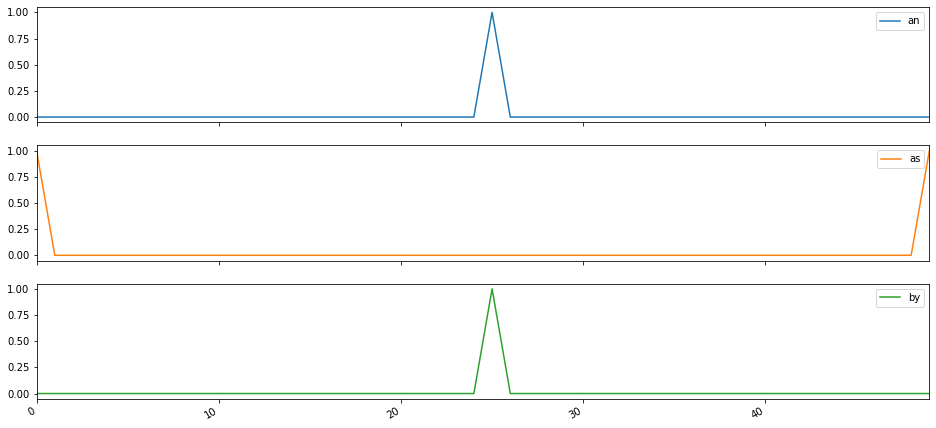

In [128]:
from pylab import rcParams
rcParams['figure.figsize'] = 16, 8

pd.DataFrame(
    {name: locations(name.lower(), en_doc) 
     for name in ['an', 'as', 'by']}
).plot(subplots=True)

Exploring [Named Entities](https://spacy.io/api/annotation)

Named entities can be accessed through doc.ents

In [129]:
set([w.label_ for w in en_doc.ents])

{'GPE'}

In [130]:
[ent for ent in en_doc.ents if ent.label_ == 'PERSON']

[]

In [131]:
[ent for ent in en_doc.ents if ent.label_ == 'GPE']

[amoeba]

Parts of Speech  

Each word already has a part of speech and a tag associated with it.

In [132]:
tagDict = {w.pos: w.pos_ for w in en_doc} 
tagDict

{103: 'SPACE',
 90: 'DET',
 84: 'ADJ',
 92: 'NOUN',
 85: 'ADP',
 96: 'PROPN',
 87: 'AUX',
 86: 'ADV',
 100: 'VERB',
 95: 'PRON',
 98: 'SCONJ',
 97: 'PUNCT',
 94: 'PART',
 101: 'X'}

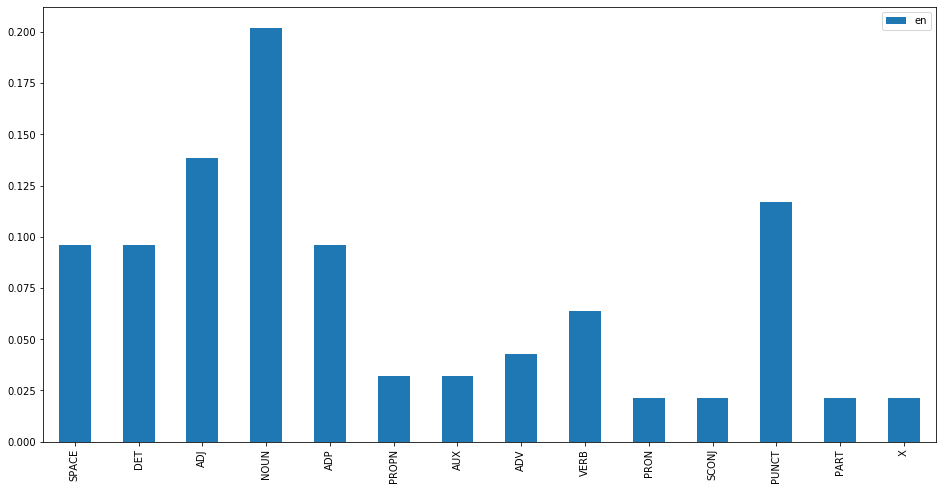

In [133]:
en_docPOS = pd.Series(en_doc.count_by(spacy.attrs.POS))/len(en_doc)

df = pd.DataFrame([en_docPOS], index=['en'])
df.columns = [tagDict[column] for column in df.columns]
df.T.plot(kind='bar')

In [134]:
en_docProns = [w for w in en_doc if w.pos_ == 'PRON']
Counter([w.string.strip() for w in en_docProns]).most_common(10)

[('me', 1), ('it', 1)]

In [135]:
en_docSents = [sent for sent in en_doc.sents if 'of' in sent.string]
en_docSents

[
 The titular threat of The Blob has always struck me as the ultimate movie
 monster: an insatiably hungry, amoeba-like mass able to penetrate
 virtually any safeguard, capable of--as a doomed doctor chillingly,
 Snide comparisons to gelatin be damned, it's a concept with the most
 devastating of potential consequences, not unlike the grey goo scenario
 proposed by technological theorists,,
 etc., fearful of
 artificial intelligence run rampant.]

In [136]:
for word in en_docSents[1]: 
    print(word, word.tag_, word.pos_)

Snide NN NOUN
comparisons NNS NOUN
to IN ADP
gelatin NN NOUN
be VB AUX
damned VBN VERB
, , PUNCT
it PRP PRON
's VBZ AUX
a DT DET
concept NN NOUN
with IN ADP
the DT DET
most JJS ADJ

 _SP SPACE
devastating JJ ADJ
of IN ADP
potential JJ ADJ
consequences NNS NOUN
, , PUNCT
not RB PART
unlike IN ADP
the DT DET
grey NN NOUN
goo NNP PROPN
scenario NN NOUN

 _SP SPACE
proposed VBN VERB
by IN ADP
technological JJ ADJ
theorists NNS NOUN
, , PUNCT


Dependency Parsing  

Now let's analyze the structure of the sentence.  

This sentence has lots of properties:  

In [137]:
[prop for prop in dir(en_docSents[1]) if not prop.startswith('_')]

['as_doc',
 'char_span',
 'conjuncts',
 'doc',
 'end',
 'end_char',
 'ent_id',
 'ent_id_',
 'ents',
 'get_extension',
 'get_lca_matrix',
 'has_extension',
 'has_vector',
 'kb_id',
 'kb_id_',
 'label',
 'label_',
 'lefts',
 'lemma_',
 'lower_',
 'merge',
 'n_lefts',
 'n_rights',
 'noun_chunks',
 'orth_',
 'remove_extension',
 'rights',
 'root',
 'sent',
 'sentiment',
 'set_extension',
 'similarity',
 'start',
 'start_char',
 'string',
 'subtree',
 'tensor',
 'text',
 'text_with_ws',
 'to_array',
 'upper_',
 'vector',
 'vector_norm',
 'vocab']

To drill down into the sentence, we can start with the root:

In [138]:
en_docSents[1].root

's

In [139]:
list(en_docSents[1].root.children)

[damned, ,, it, concept, ,, unlike]

In [140]:
for word in en_docSents[1]: 
    print(word, ': ', str(list(word.children)))

Snide :  []
comparisons :  [Snide, to]
to :  [gelatin]
gelatin :  []
be :  []
damned :  [comparisons, be]
, :  []
it :  []
's :  [damned, ,, it, concept, ,, unlike]
a :  []
concept :  [a, with]
with :  [devastating]
the :  []
most :  [
]

 :  []
devastating :  [the, most, of]
of :  [consequences]
potential :  []
consequences :  [potential]
, :  []
not :  []
unlike :  [not, scenario]
the :  []
grey :  []
goo :  [grey]
scenario :  [the, goo, 
, proposed]

 :  []
proposed :  [by]
by :  [theorists]
technological :  []
theorists :  [technological, ,]
, :  []


In [141]:
for sent in en_docSents: 
    for word in sent: 
        if 'as' in word.string: 
            for child in word.children: 
                if child.pos_ == 'ADJ':
                    print(child)

hungry
like
able
most


In [142]:
Counter([w.string.strip() for w in en_doc.ents if w.label_ == 'PERSON']).most_common(10)

[]

Now we can write a function that walks down the tree from each character, looking for the first adjectives it can find:

In [143]:
def adjectivesDescribingCharacters(text, character):
    sents = [sent for sent in text.sents if character in sent.string]
    adjectives = []
    for sent in sents: 
        for word in sent: 
            if character in word.string:
                for child in word.children: 
                    if child.pos_ == 'ADJ': 
                        adjectives.append(child.string.strip())
    return Counter(adjectives).most_common(10)

In [144]:
adjectivesDescribingCharacters(en_doc, 'Blob')

[]

or verbs:

In [145]:
def verbsForCharacters(text, character):
    sents = [sent for sent in text.sents if character in sent.string]
    charWords = []
    for sent in sents: 
        for word in sent: 
            if character in word.string: 
                charWords.append(word)
    charAdjectives = []
    for word in charWords: 
        # Start walking up the list of ancestors 
        # Until we get to the first verb. 
        for ancestor in word.ancestors: 
            if ancestor.pos_.startswith('V'): 
                charAdjectives.append(ancestor.lemma_.strip())
    return Counter(charAdjectives).most_common(20)

In [146]:
verbsForCharacters(en_doc, 'Blob')

[('strike', 1)]

Probabilities

SpaCy has a list of probabilities for English words, and these probabilities are automatically associated with each word once we parse the document.  
Let's see what the distribution is like:

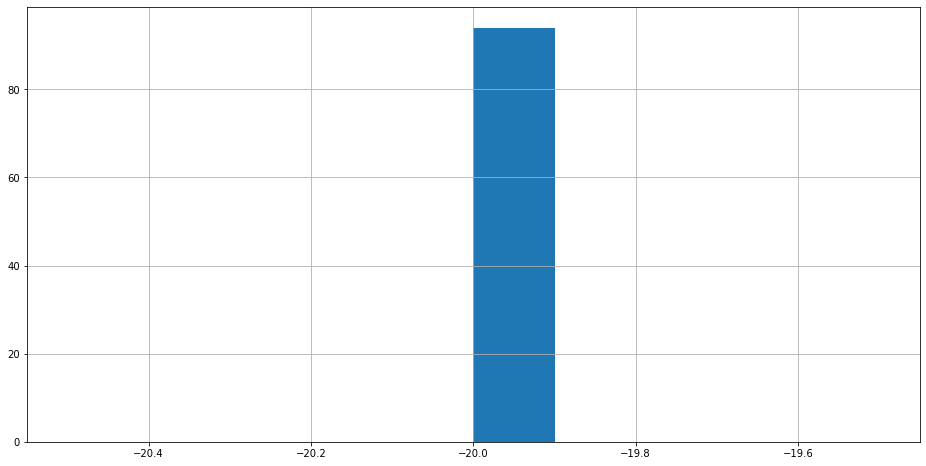

In [147]:
probabilities = [word.prob for word in en_doc] 
pd.Series(probabilities).hist()

Let's peek at some of the improbable words

In [148]:
list(set([word.string.strip().lower() for word in en_doc if word.prob < -19]))[:20]

['',
 'titular',
 'struck',
 'has',
 'doctor',
 'artificial',
 ',',
 'goo',
 ':',
 'like',
 'always',
 'to',
 'as',
 'proposed',
 'capable',
 'devastating',
 'threat',
 'hungry',
 'grey',
 'technological']

In [149]:
Counter([word.string.strip().lower() 
         for word in en_doc 
         if word.prob < -19.5]).most_common(20)

[('', 9),
 (',', 6),
 ('the', 5),
 ('of', 4),
 ('.', 3),
 ('as', 2),
 ('to', 2),
 ('a', 2),
 ('titular', 1),
 ('threat', 1),
 ('blob', 1),
 ('has', 1),
 ('always', 1),
 ('struck', 1),
 ('me', 1),
 ('ultimate', 1),
 ('movie', 1),
 ('monster', 1),
 (':', 1),
 ('an', 1)]

In [150]:
def ngrams(doc, n): 
    doc = [word for word in doc 
           if word.is_alpha # Get rid of punctuation
           if not word.string.isupper()] # Get rid of all-caps speaker headings
    return list(zip(*[doc[i:] for i in range(n)]))

In [151]:
docGrams = set(ngrams(en_doc, 3))

In [152]:
for gram in docGrams: 
    if sum([word.prob for word in gram]) < -40: 
        print(gram)

(safeguard, capable, of)
(concept, with, the)
(devastating, of, potential)
(as, the, ultimate)
(of, The, Blob)
(grey, goo, scenario)
(damned, it, a)
(has, always, struck)
(of, potential, consequences)
(potential, consequences, not)
(the, ultimate, movie)
(fearful, of, artificial)
(chillingly, describes, flesh)
(hungry, amoeba, like)
(most, devastating, of)
(mass, able, to)
(theorists, etc, fearful)
(of, as, a)
(amoeba, like, mass)
(always, struck, me)
(Blob, has, always)
(etc, fearful, of)
(doomed, doctor, chillingly)
(The, Blob, has)
(comparisons, to, gelatin)
(technological, theorists, etc)
(artificial, intelligence, run)
(a, concept, with)
(to, gelatin, be)
(consequences, not, unlike)
(the, most, devastating)
(any, safeguard, capable)
(The, titular, threat)
(able, to, penetrate)
(goo, scenario, proposed)
(to, penetrate, virtually)
(a, doomed, doctor)
(struck, me, as)
(titular, threat, of)
(unlike, the, grey)
(as, a, doomed)
(scenario, proposed, by)
(penetrate, virtually, any)
(flesh

## Example 3 - Full EDA text pipeline based in [this](https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools) and [this](https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/) articles  

### Analyzing text statistics

Text statistics visualizations are simple but very insightful techniques. 

They include:

- word frequency analysis,
- sentence length analysis,
- average word length analysis

In [158]:
news= pd.read_csv(os.path.join(datapath, 'Texts','abcnews-date-text.csv'),nrows=10000)
news.head(3)

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit


#### First, let's take a look at the number of characters present in each sentence. This can give us a rough idea about the news headline length.

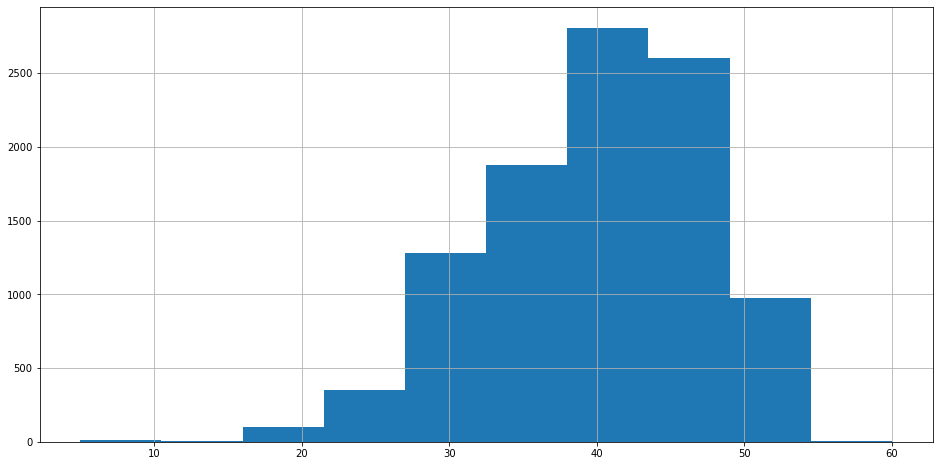

In [159]:
news['headline_text'].str.len().hist()

#### Now, we will move on to data exploration at a word-level. Let’s plot the number of words appearing in each news headline.

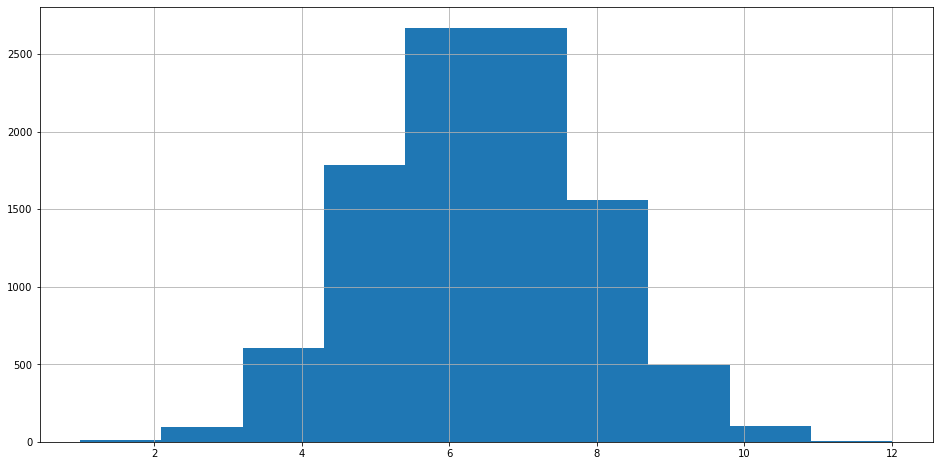

In [160]:
news['headline_text'].str.split().map(lambda x: len(x)).hist()

#### Up next, let’s check the average word length in each sentence.

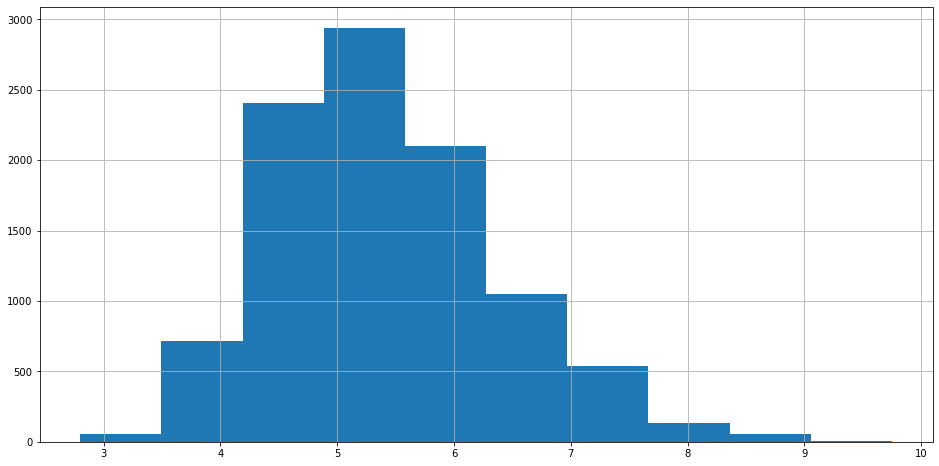

In [161]:
news['headline_text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

#### Loading stopwords list

In [162]:
#import nltk
#nltk.download('stopwords')
stop = set(nltk.corpus.stopwords.words('english'))

#### Now, we’ll  create the corpus.

In [163]:
corpus=[]
new = news['headline_text'].str.split()
new = new.values.tolist()
corpus = [word for i in new for word in i]

#### Plot top stopwords

<BarContainer object of 10 artists>

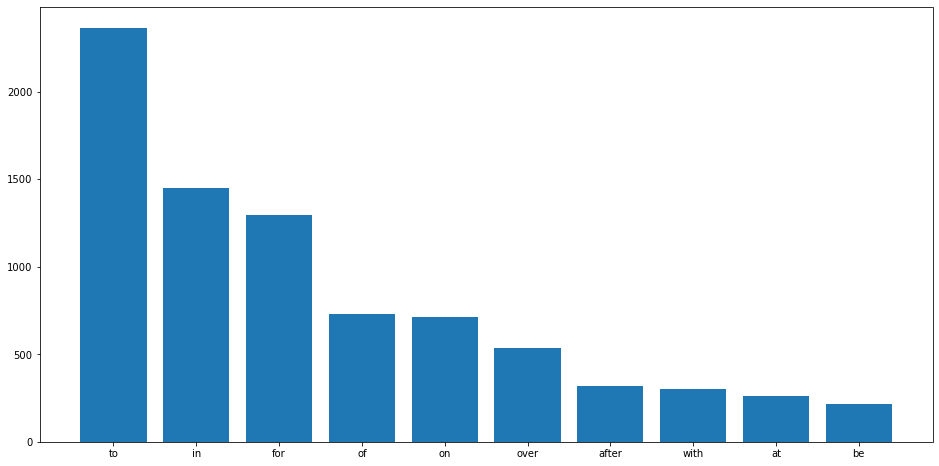

In [164]:
dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] += 1
top = sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y = zip(*top)
plt.bar(x,y)

#### We will use the counter function from the collections library to count and store the occurrences of each word in a list of tuples.

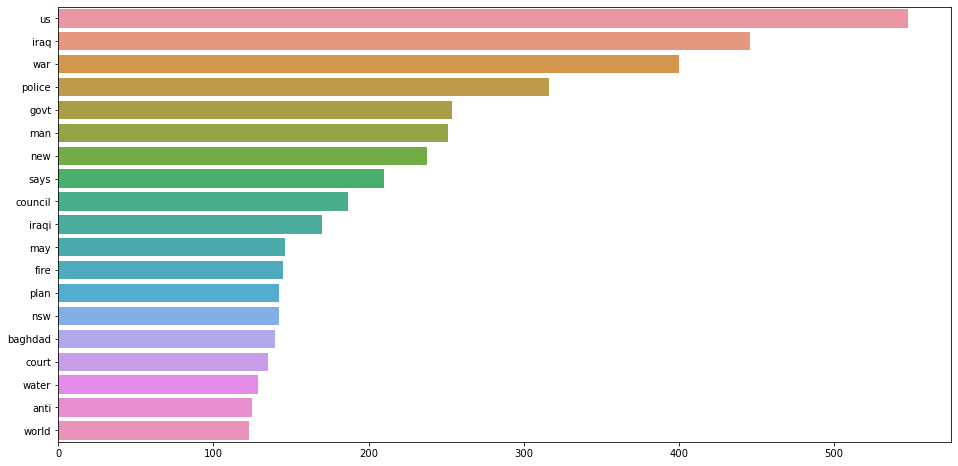

In [165]:
counter = Counter(corpus)
most = counter.most_common()

x, y = [], []
for word,count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

#### Ngram exploration  

Ngrams are simply contiguous sequences of n words.   

Looking at most frequent n-grams can give you a better understanding of the context in which the word was used.  

In [166]:
from nltk.util import ngrams
list(ngrams(['I' ,'went','to','the','river','bank'],2))

[('I', 'went'),
 ('went', 'to'),
 ('to', 'the'),
 ('the', 'river'),
 ('river', 'bank')]

#### To build a representation of our vocabulary we will use Countvectorizer.

In [167]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

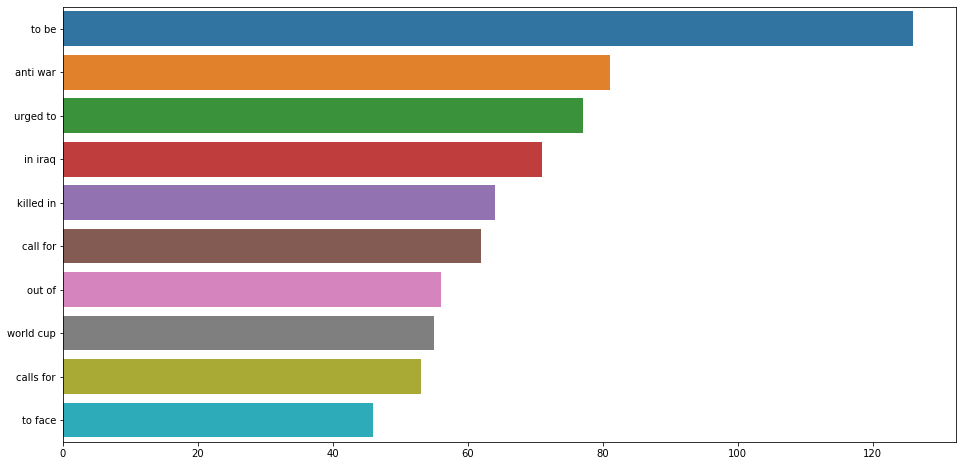

In [168]:
top_n_bigrams=get_top_ngram(news['headline_text'],2)[:10]
x,y = map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

#### How about trigrams?

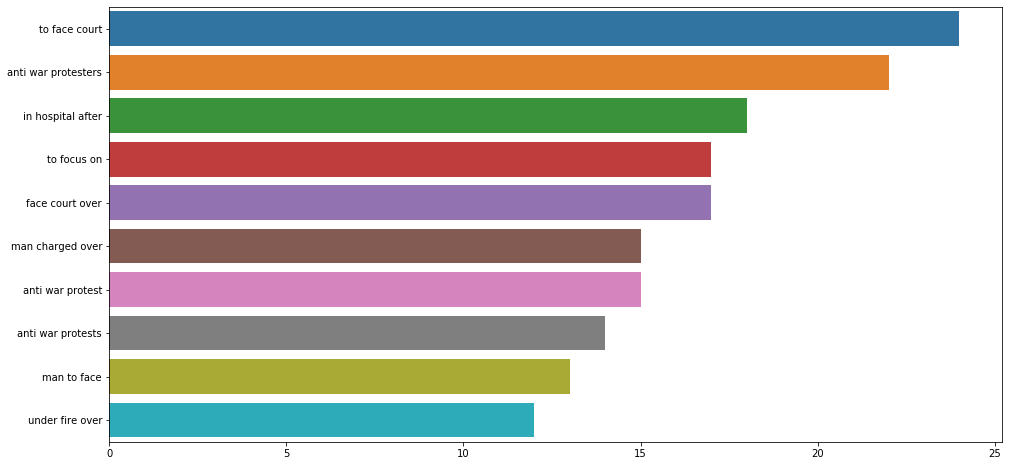

In [169]:
top_tri_grams=get_top_ngram(news['headline_text'],n=3)
x,y = map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x)

#### Topic Modeling exploration with pyLDAvis

In [170]:
nltk.download('punkt')
nltk.download('wordnet')

def preprocess_news(df):
    corpus = []
    stem = nltk.stem.PorterStemmer()
    lem = nltk.stem.WordNetLemmatizer()
    for news in df['headline_text']:
        words=[w for w in nltk.tokenize.word_tokenize(news) if (w not in stop)]
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        corpus.append(words)
    return corpus

corpus = preprocess_news(news)

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Now, let’s create the bag of words model using gensim

In [171]:
dic = gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

#### Create the LDA model:

In [172]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics = 4, id2word = dic, passes = 10, workers = 2,  per_word_topics=True)
lda_model.show_topics()

[(0,
  '0.012*"man" + 0.008*"face" + 0.008*"plan" + 0.007*"call" + 0.006*"charge" + 0.005*"court" + 0.005*"troop" + 0.005*"may" + 0.005*"govt" + 0.004*"hospital"'),
 (1,
  '0.012*"iraqi" + 0.009*"war" + 0.008*"iraq" + 0.007*"win" + 0.007*"death" + 0.007*"police" + 0.006*"attack" + 0.006*"say" + 0.006*"back" + 0.005*"world"'),
 (2,
  '0.021*"war" + 0.010*"council" + 0.008*"new" + 0.008*"iraq" + 0.007*"anti" + 0.007*"protest" + 0.004*"return" + 0.004*"plan" + 0.004*"coast" + 0.004*"rain"'),
 (3,
  '0.014*"iraq" + 0.011*"baghdad" + 0.005*"govt" + 0.005*"force" + 0.005*"report" + 0.005*"say" + 0.005*"fire" + 0.004*"lead" + 0.004*"public" + 0.004*"police"')]

#### What is the Dominant topic and its percentage contribution in each document

In [173]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), 
                                                                  round(prop_topic,4), 
                                                                  topic_keywords]), 
                                                       ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(lda_model, bow_corpus, news['headline_text'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.6638,"iraq, baghdad, govt, force, report, say, fire,...",aba decides against community broadcasting lic...
1,1,0.0,0.8852,"man, face, plan, call, charge, court, troop, m...",act fire witnesses must be aware of defamation
2,2,0.0,0.5960,"man, face, plan, call, charge, court, troop, m...",a g calls for infrastructure protection summit
3,3,2.0,0.8868,"war, council, new, iraq, anti, protest, return...",air nz staff in aust strike for pay rise
4,4,3.0,0.4746,"iraq, baghdad, govt, force, report, say, fire,...",air nz strike to affect australian travellers
5,5,1.0,0.8732,"iraqi, war, iraq, win, death, police, attack, ...",ambitious olsson wins triple jump
6,6,2.0,0.4892,"war, council, new, iraq, anti, protest, return...",antic delighted with record breaking barca
7,7,0.0,0.9025,"man, face, plan, call, charge, court, troop, m...",aussie qualifier stosur wastes four memphis match
8,8,2.0,0.8685,"war, council, new, iraq, anti, protest, return...",aust addresses un security council over iraq
9,9,0.0,0.6814,"man, face, plan, call, charge, court, troop, m...",australia is locked into war timetable opp


#### Frequency Distribution of Word Counts in Documents

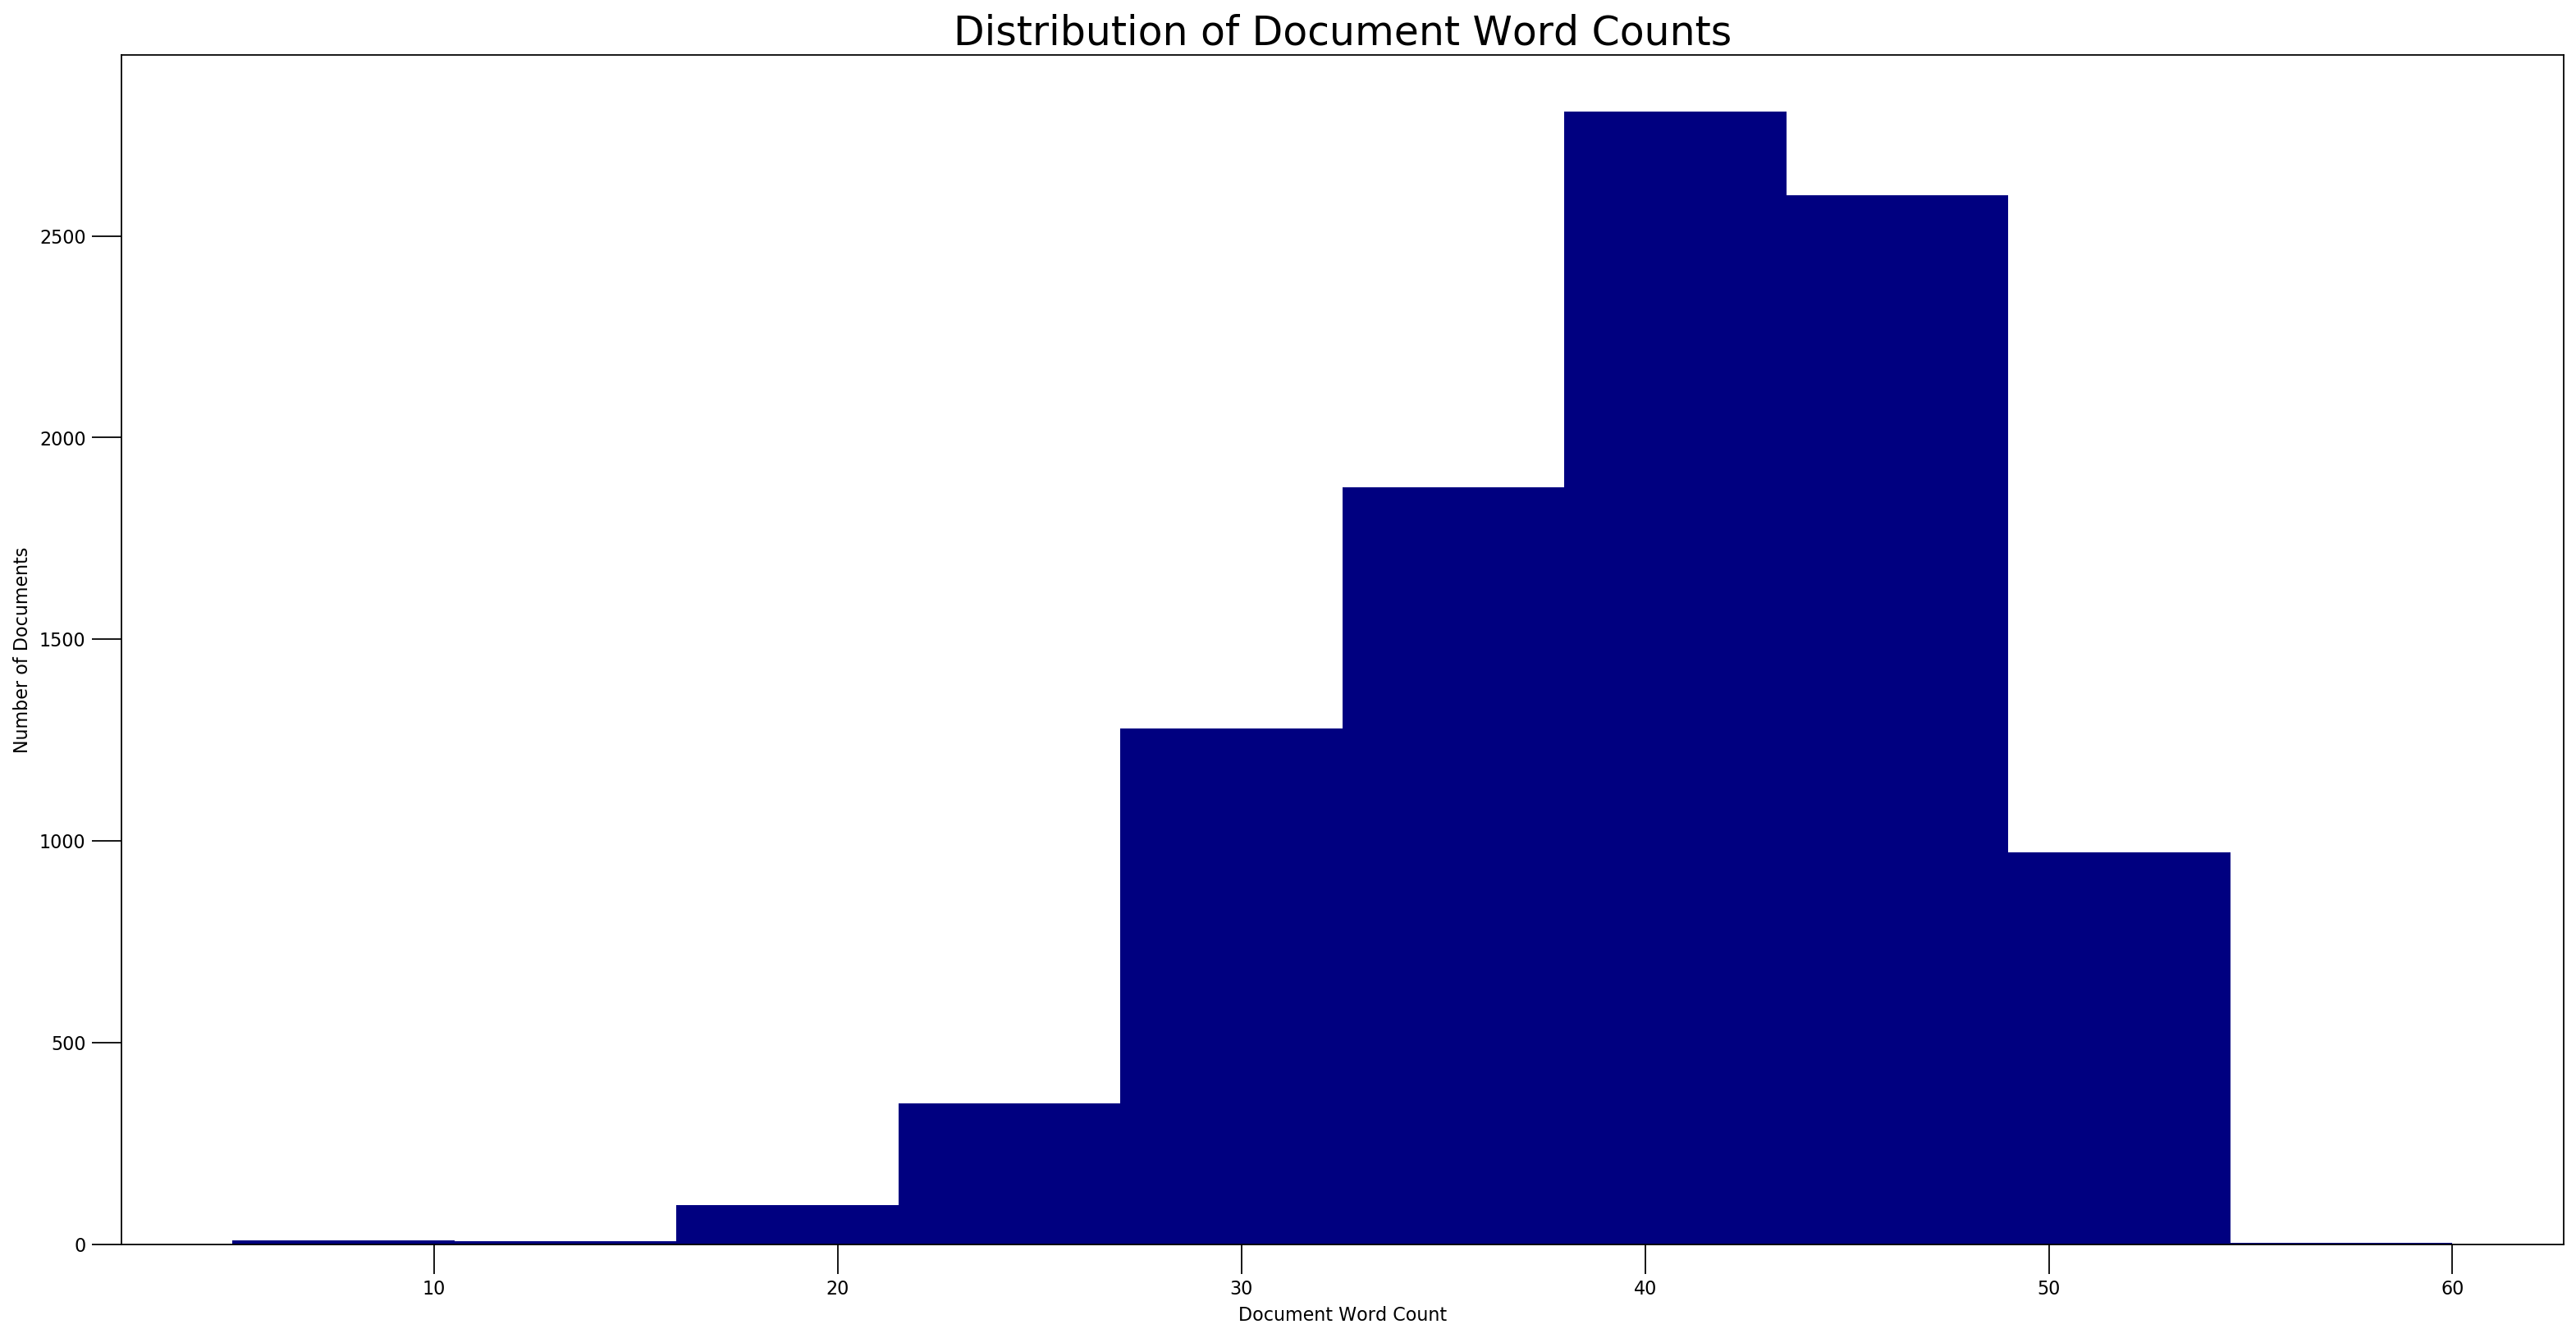

In [174]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(24,12), dpi=160)
plt.hist(doc_lens, color='navy') #, bins = 100)
#plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
#plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
#plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
#plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
#plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(ylabel='Number of Documents', xlabel='Document Word Count',) # xlim=(0, 100),)
plt.tick_params(size=16)
#plt.xticks(np.linspace(0,100,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

#### By Topic

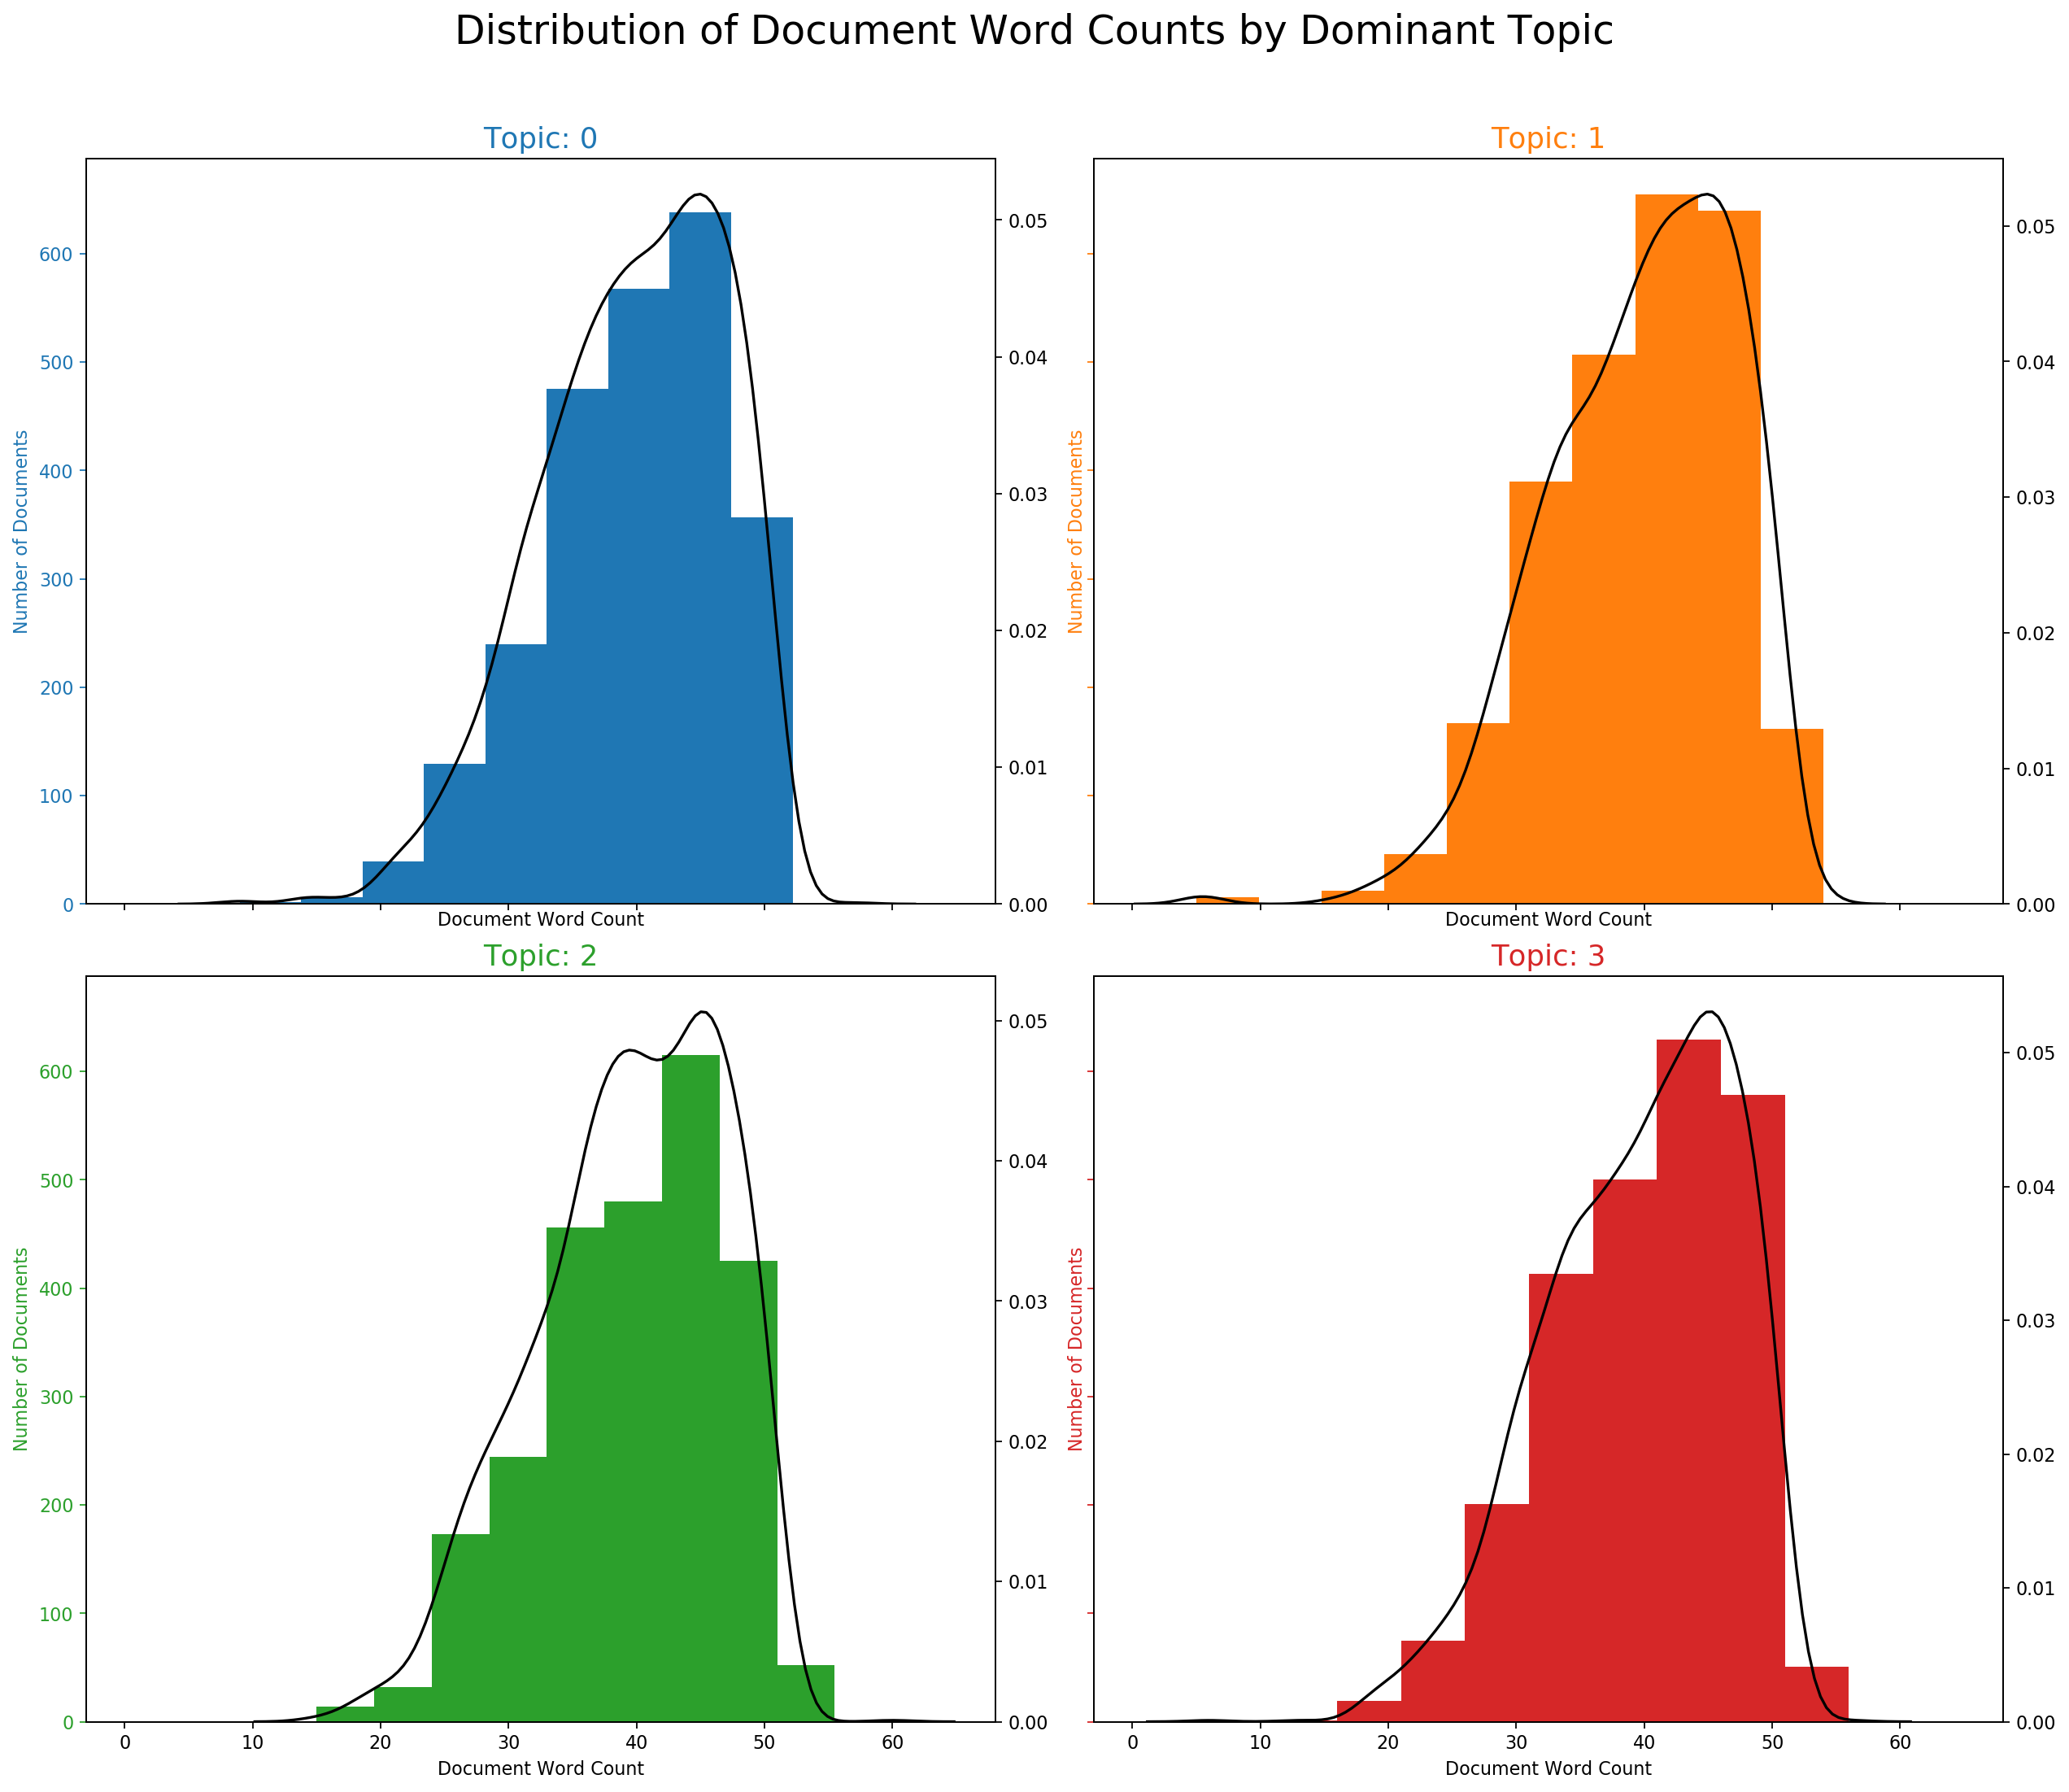

In [175]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, color=cols[i]) #, bins = 1000)
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlabel='Document Word Count') #xlim=(0, 1000),
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
#plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

#### Word Clouds of Top N Keywords in Each Topic

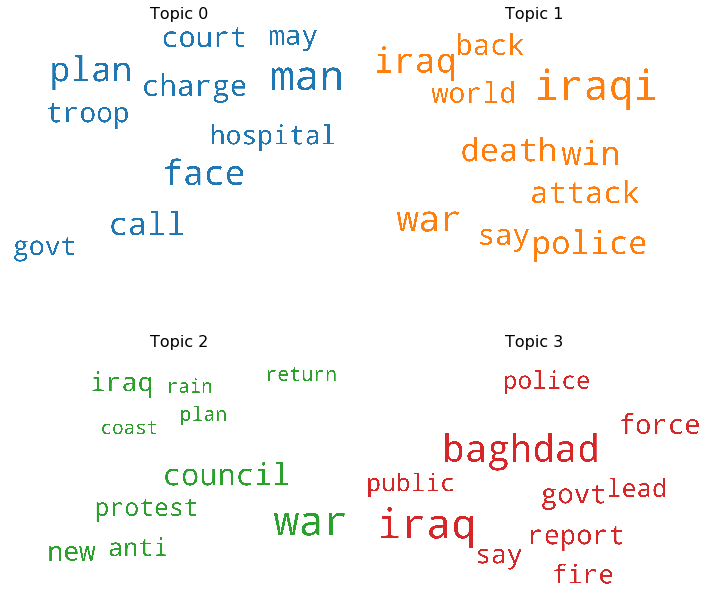

In [176]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

#### Word Counts of Topic Keywords

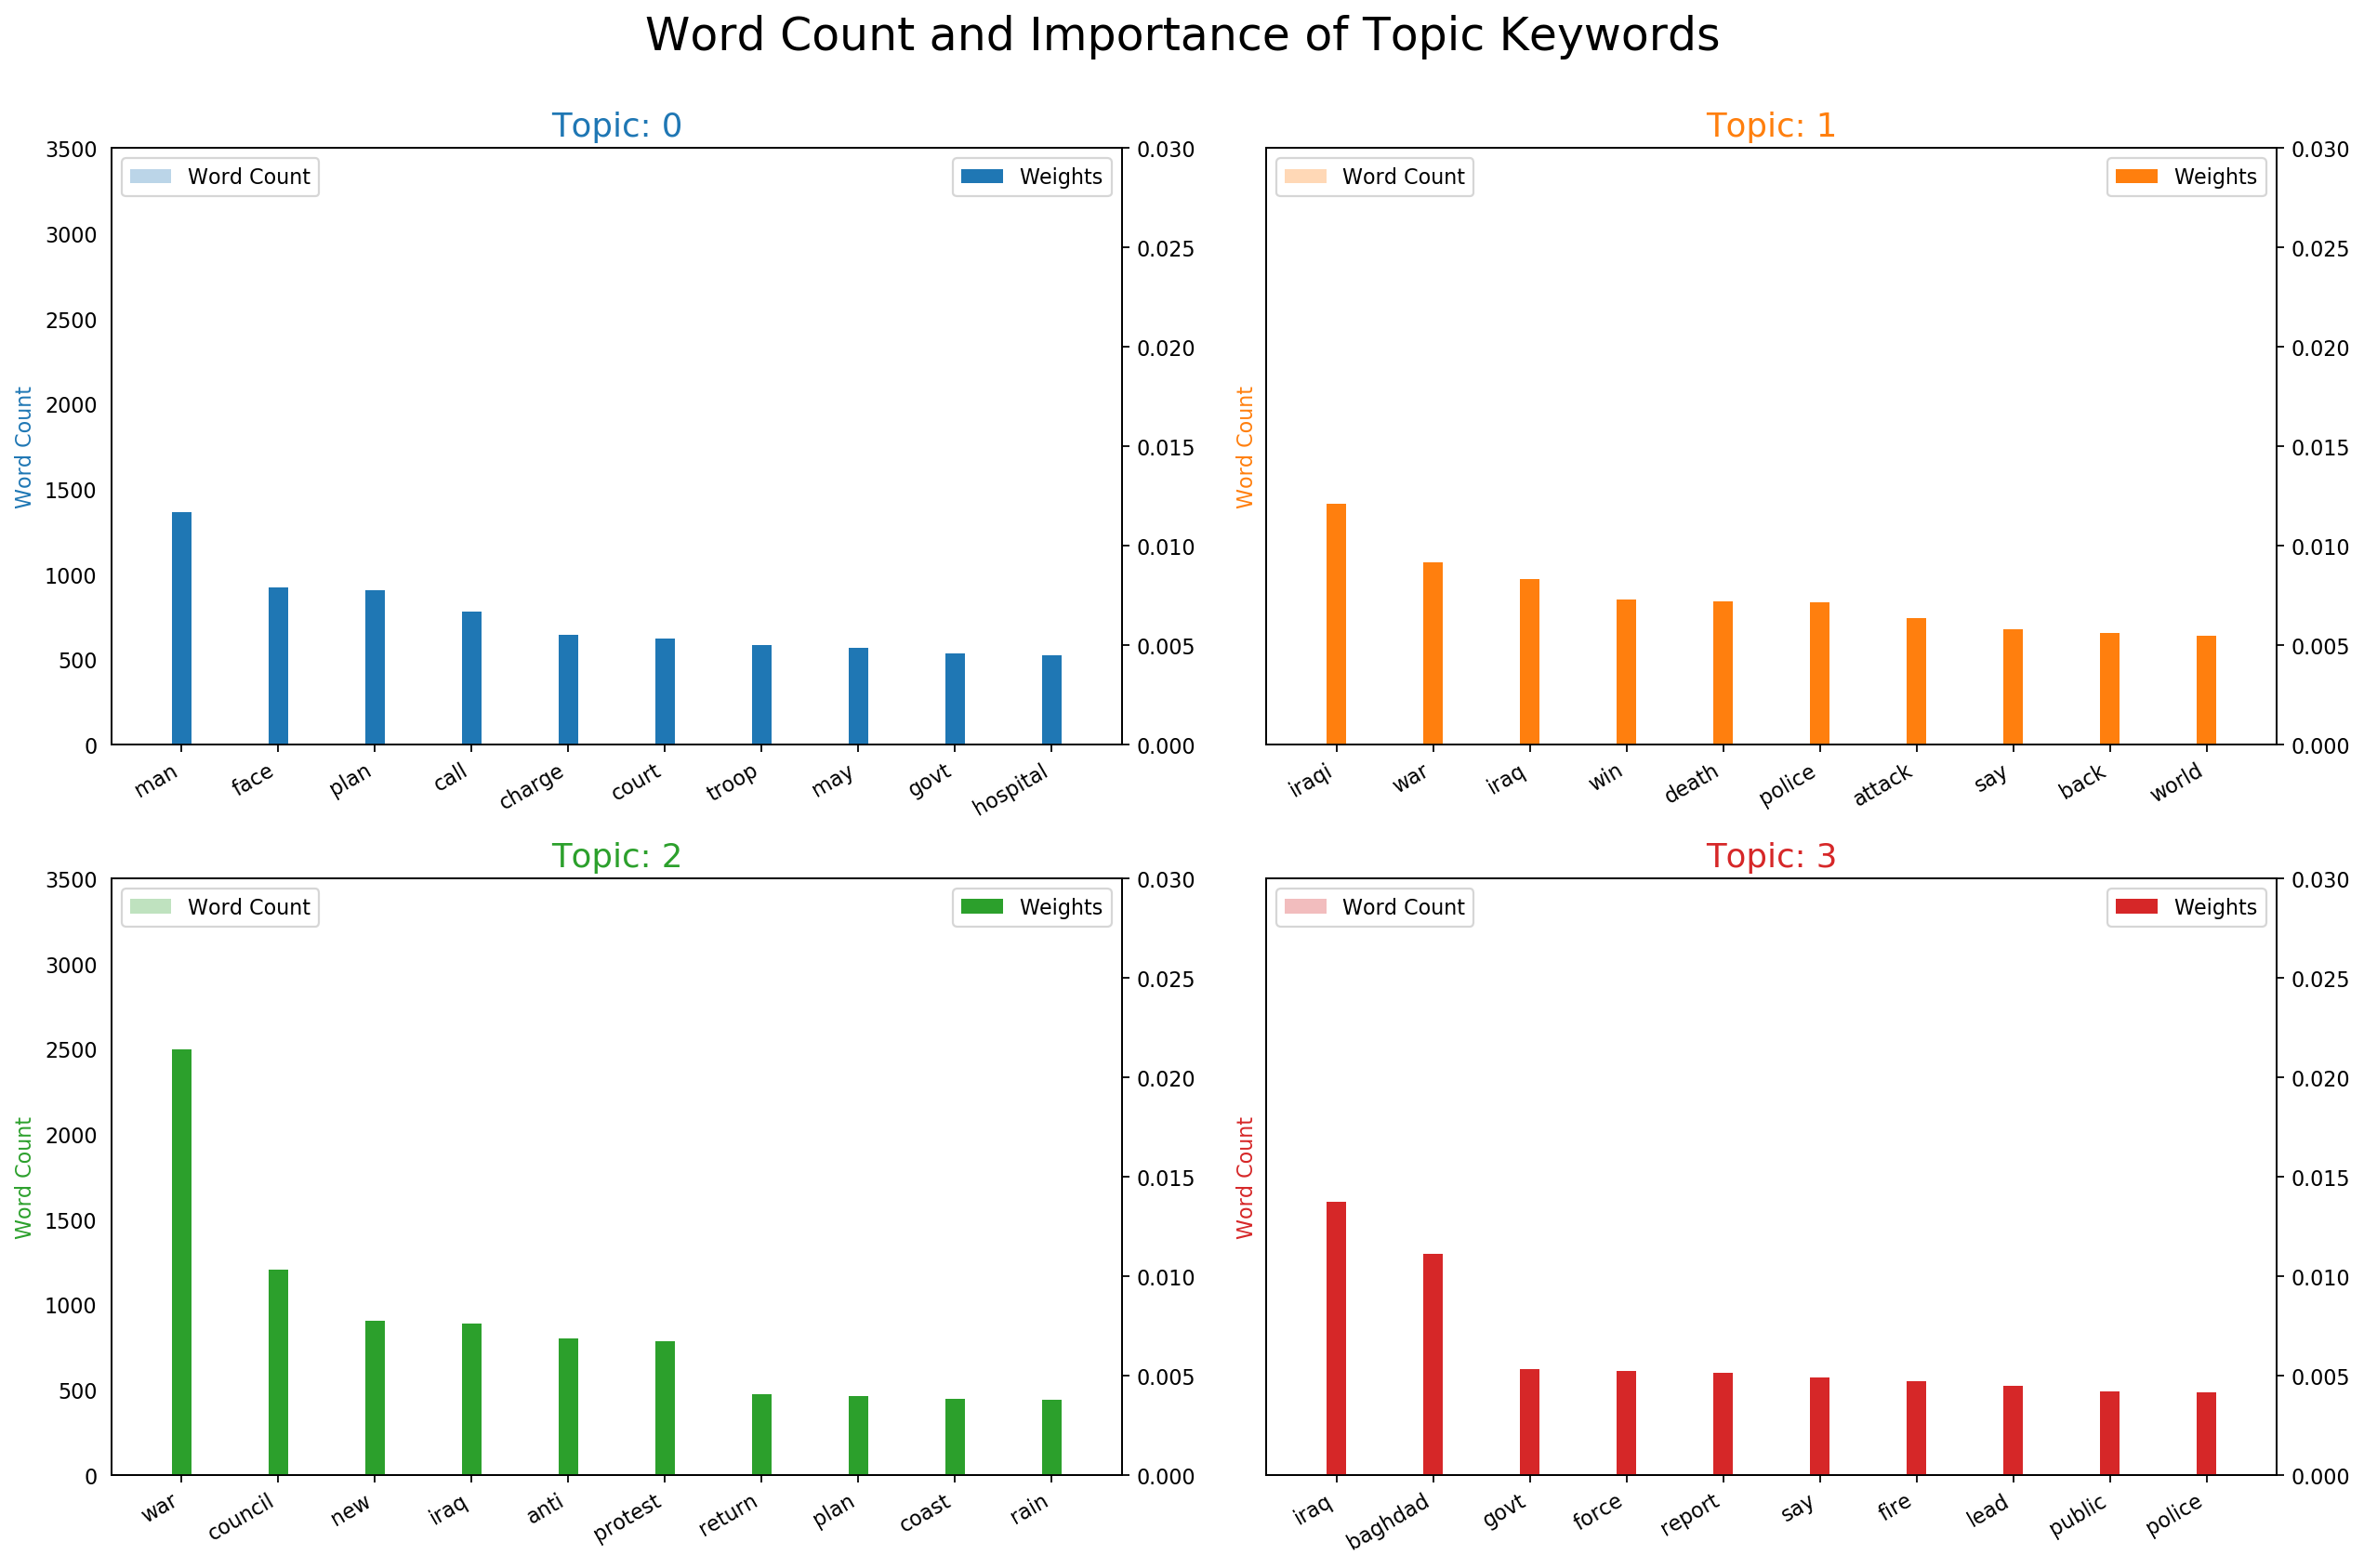

In [177]:
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in news['headline_text'] for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

#### Sentence Chart Colored by Topic

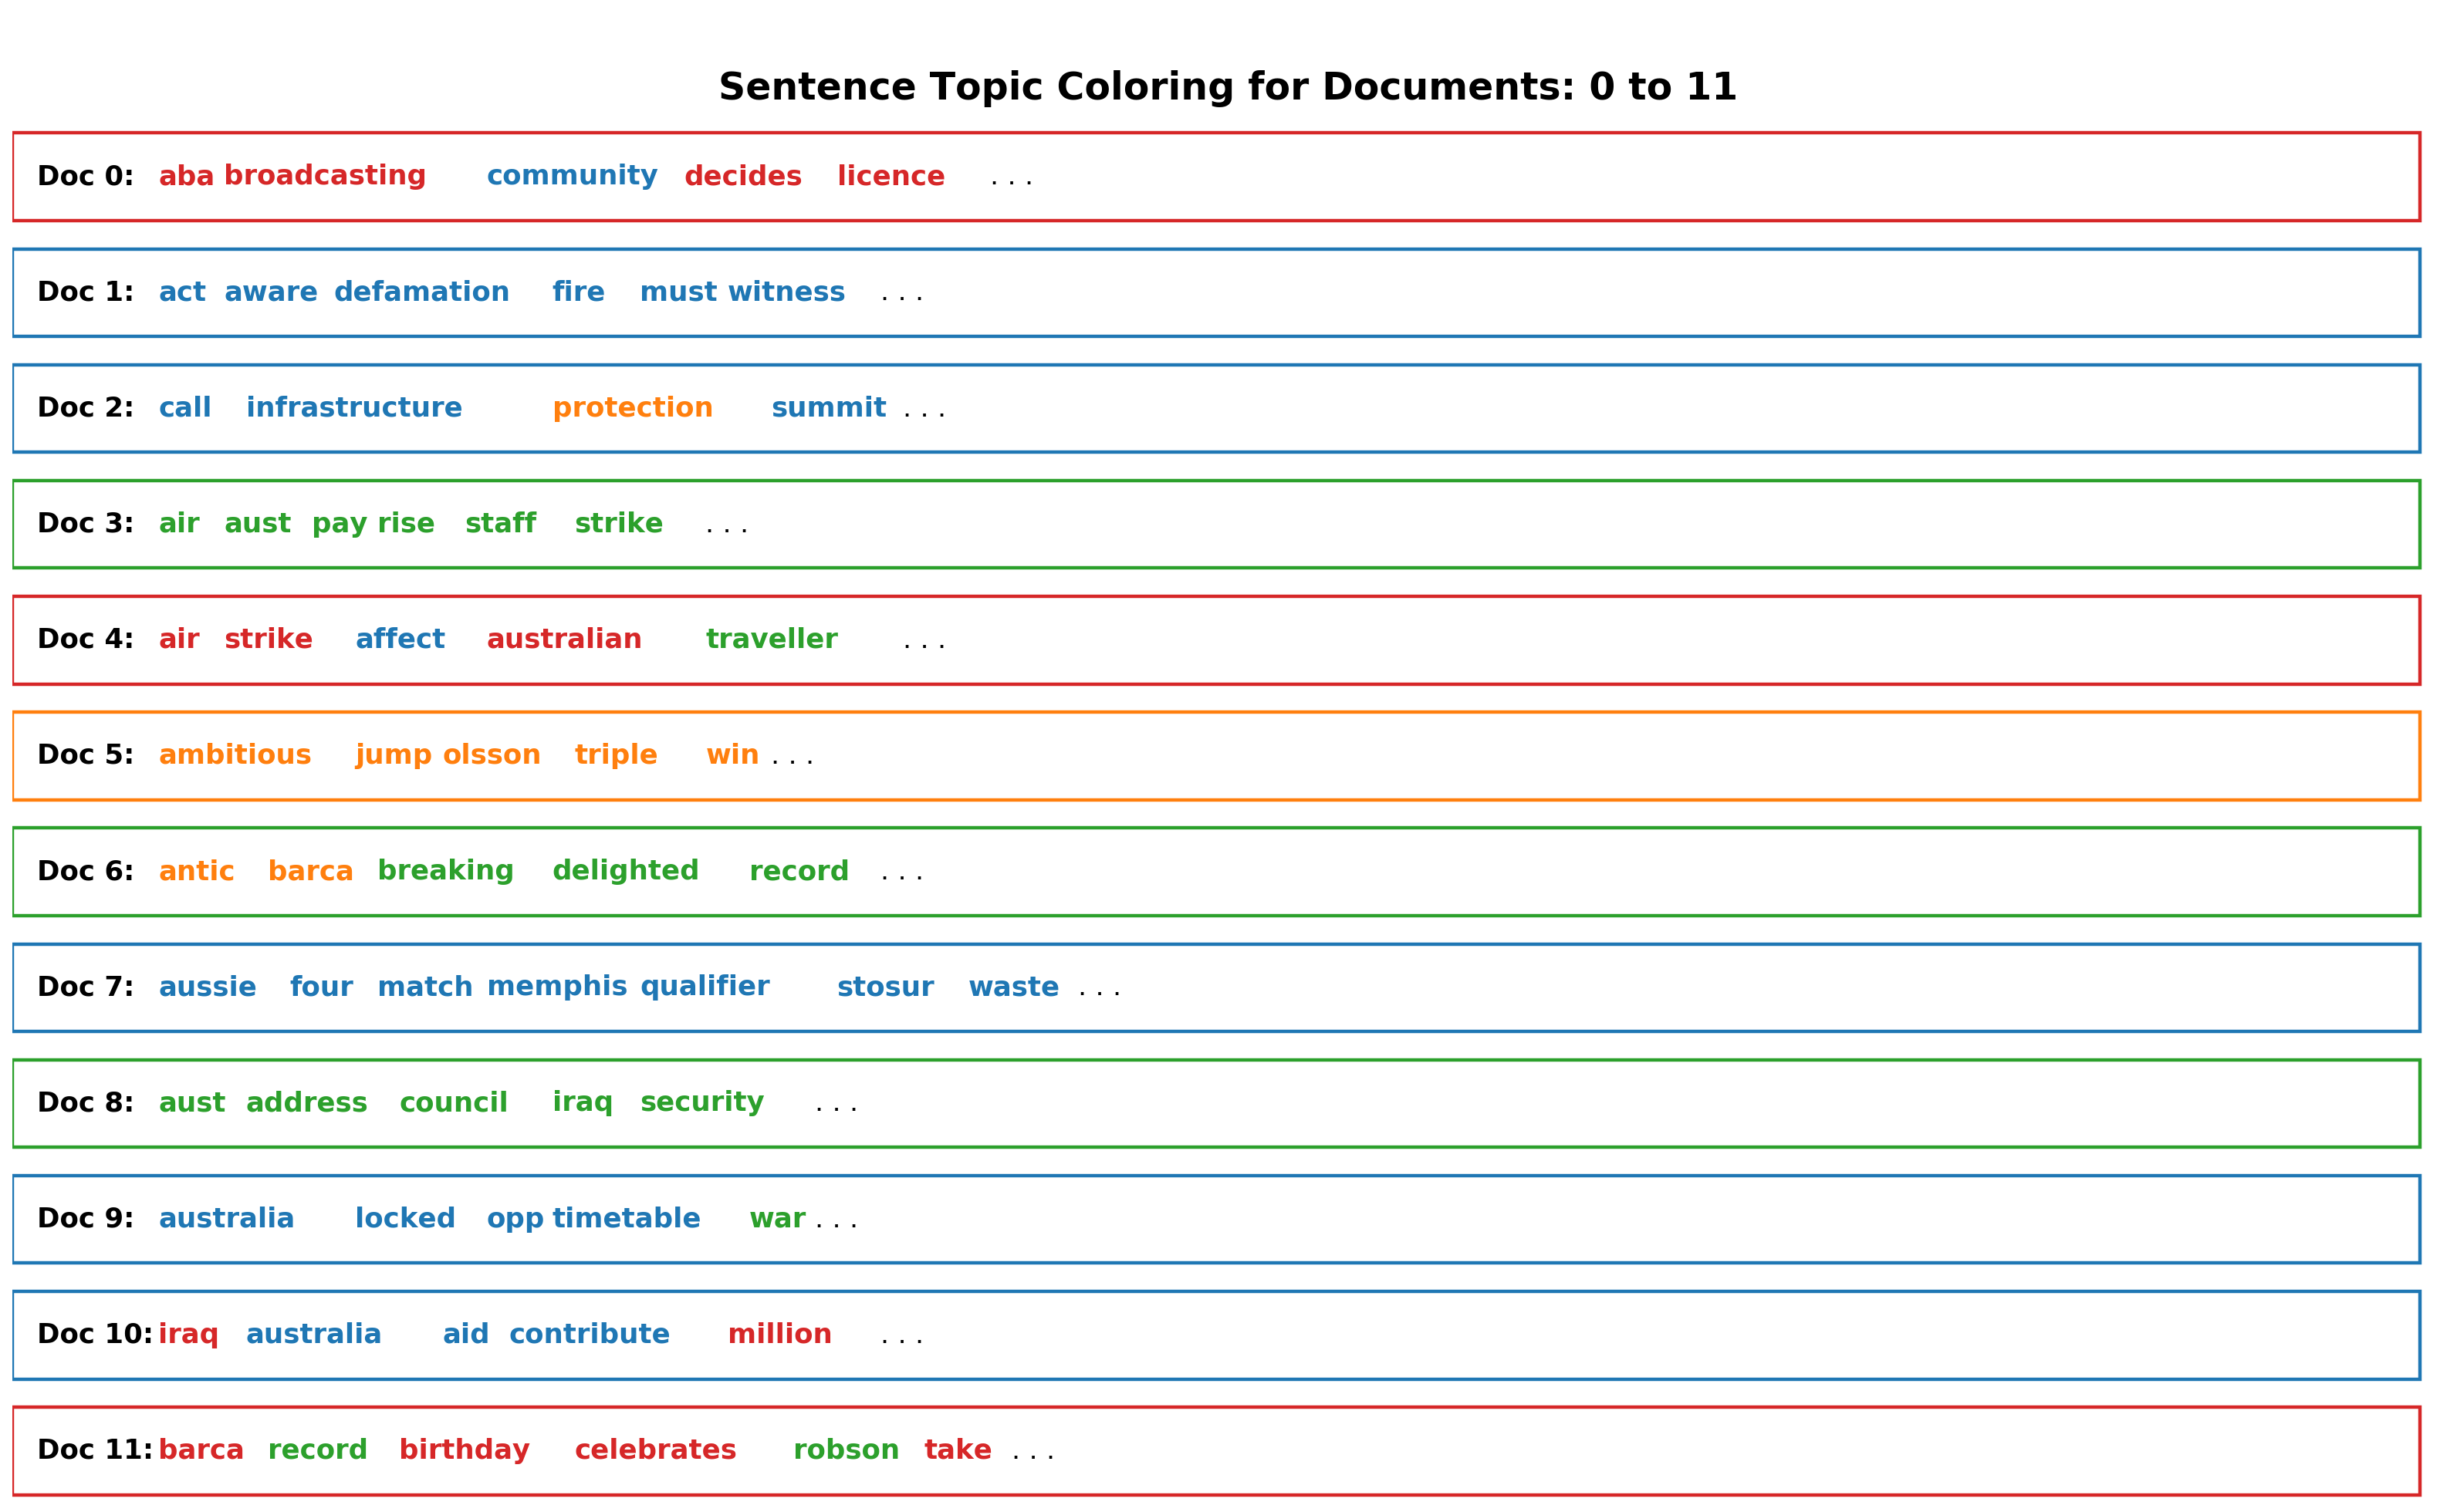

In [178]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model, corpus, start=0, end=13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 
                    0.5, 
                    "Doc " + str(i-1) + ": ", 
                    verticalalignment='center',
                    fontsize=16, 
                    color='black',
                    transform=ax.transAxes, 
                    fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color = mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment = 'left',
                            verticalalignment = 'center',
                            fontsize = 16, color = mycolors[topics],
                            transform = ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
                    
            ax.text(word_pos, 0.5, 
                    '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart(lda_model, bow_corpus)    

#### What are the most discussed topics in the documents?

In [179]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=bow_corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0, inplace=True)

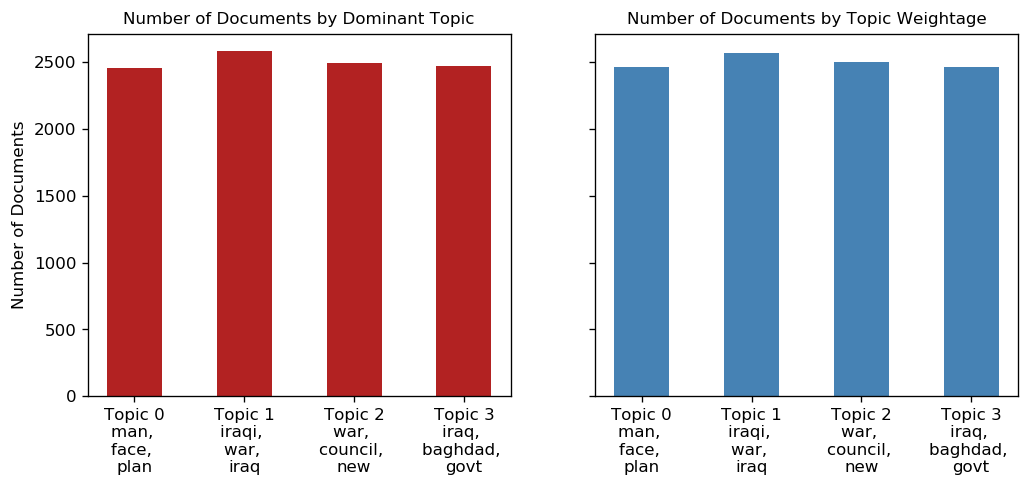

In [180]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
# ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

#### t-SNE Clustering Chart

In [181]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[bow_corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 6
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9973 samples in 0.007s...
[t-SNE] Computed neighbors for 9973 samples in 0.165s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9973
[t-SNE] Computed conditional probabilities for sample 2000 / 9973
[t-SNE] Computed conditional probabilities for sample 3000 / 9973
[t-SNE] Computed conditional probabilities for sample 4000 / 9973
[t-SNE] Computed conditional probabilities for sample 5000 / 9973
[t-SNE] Computed conditional probabilities for sample 6000 / 9973
[t-SNE] Computed conditional probabilities for sample 7000 / 9973
[t-SNE] Computed conditional probabilities for sample 8000 / 9973
[t-SNE] Computed conditional probabilities for sample 9000 / 9973
[t-SNE] Computed conditional probabilities for sample 9973 / 9973
[t-SNE] Mean sigma: 0.000992
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.046963
[t-SNE] KL divergence after 1000 iterations: 0.748033


Loading BokehJS ...

#### Visualizes the results of LDA interactively

In [182]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
vis

/opt/conda/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.125930 -0.091135       1        1  25.815088
2      0.149028 -0.103613       2        1  24.932991
0      0.057806  0.142170       3        1  24.643602
3     -0.080904  0.052578       4        1  24.608316, topic_info=     Category        Freq     Term       Total  loglift  logprob
49    Default  395.000000      war  395.000000  30.0000  30.0000
171   Default  205.000000    iraqi  205.000000  29.0000  29.0000
3495  Default  192.000000  baghdad  192.000000  28.0000  28.0000
42    Default  172.000000  council  172.000000  27.0000  27.0000
493   Default  103.000000     face  103.000000  26.0000  26.0000
...       ...         ...      ...         ...      ...      ...
422    Topic4   42.444969    claim  145.469910   0.1703  -5.6893
171    Topic4   44.759430    iraqi  205.141632  -0.1203  -5.6362
437    Topic4   42.623913      new  201.893600  -0.1532  -5.6851
359    Topic4   31.948631  missing   72.299698   0.5854  -5.9734
317    Topic4   37.065475      man  206.031769  -0.3133  -5.8248

[297 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
372       1  0.951735  aboriginal
715       2  0.961360     accuses
5         3  0.670588         act
5         4  0.327116         act
6797      4  0.931048         adf
...     ...       ...         ...
488       1  0.660114       world
488       2  0.119187       world
488       4  0.220038       world
440       1  0.145647    zimbabwe
440       2  0.837470    zimbabwe

[467 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 4])

#### Wordcloud

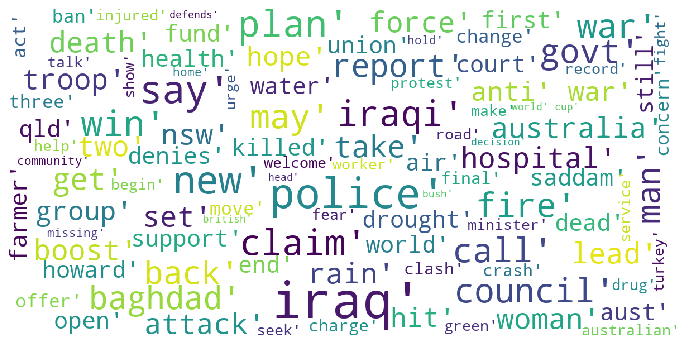

In [183]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(corpus)

#### Sentiment analysis

In [184]:
from textblob import TextBlob
TextBlob('100 people killed in Iraq').sentiment

Sentiment(polarity=-0.2, subjectivity=0.0)

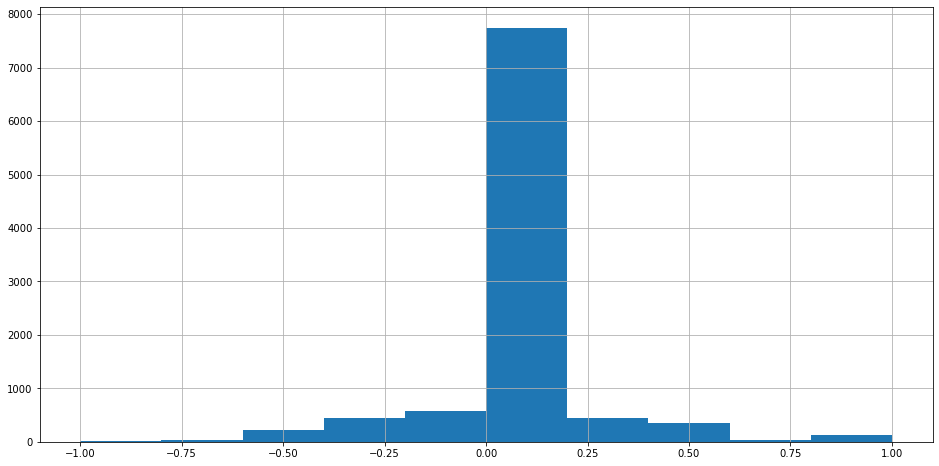

In [185]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

news['polarity_score'] = news['headline_text'].apply(lambda x : polarity(x))
news['polarity_score'].hist()

#### Let’s dig a bit deeper by classifying the news as negative, positive and neutral based on the scores.

<BarContainer object of 3 artists>

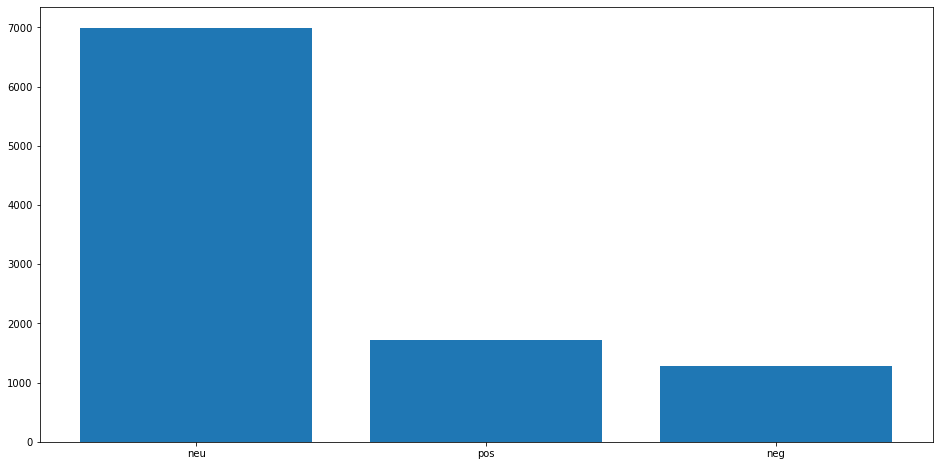

In [186]:
def sentiment(x):
    if x < 0:
        return 'neg'
    elif x == 0:
        return 'neu'
    else:
        return 'pos'
    
news['polarity']=news['polarity_score'].map(lambda x: sentiment(x))
plt.bar(news.polarity.value_counts().index, news.polarity.value_counts())

In [187]:
news[news['polarity'] == 'pos']['headline_text'].head()

1     act fire witnesses must be aware of defamation
5                  ambitious olsson wins triple jump
6         antic delighted with record breaking barca
18        bryant leads lakers to double overtime win
26      commonwealth bank cuts fixed home loan rates
Name: headline_text, dtype: object

In [188]:
news[news['polarity'] == 'neg']['headline_text'].head()

7     aussie qualifier stosur wastes four memphis match
23               carews freak goal leaves roma in ruins
28     council chief executive fails to secure position
34                   dargo fire threat expected to rise
40        direct anger at govt not soldiers crean urges
Name: headline_text, dtype: object

#### Vader Sentiment Analysis

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...


<BarContainer object of 3 artists>

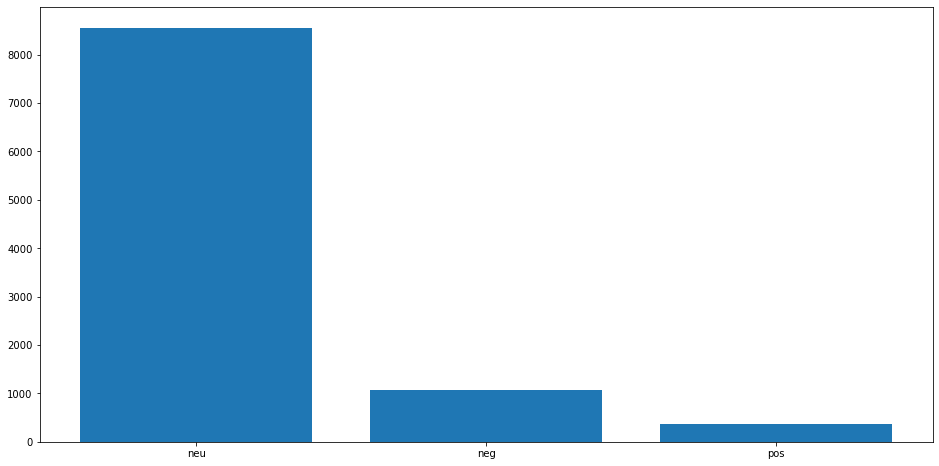

In [189]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

def get_vader_score(sent):
    # Polarity score returns dictionary
    ss = sid.polarity_scores(sent)
    #return ss
    return np.argmax(list(ss.values())[:-1])

news['polarity']=news['headline_text'].map(lambda x: get_vader_score(x))
polarity=news['polarity'].replace({0:'neg',1:'neu',2:'pos'})

plt.bar(polarity.value_counts().index, polarity.value_counts())

#### Named Entity Recognition

In [190]:
# ! python -m spacy download en_core_web_sm

nlp = spacy.load("en_core_web_sm")

In [191]:
doc = nlp('India and Iran have agreed to boost the economic viability \
of the strategic Chabahar port through various measures, \
including larger subsidies to merchant shipping firms using the facility, \
people familiar with the development said on Thursday.')

[(x.text,x.label_) for x in doc.ents]

[('India', 'GPE'), ('Iran', 'GPE'), ('Chabahar', 'NORP'), ('Thursday', 'DATE')]

In [192]:
from spacy import displacy

displacy.render(doc, style='ent')

In [193]:
def ner(text):
    doc = nlp(text)
    return [X.label_ for X in doc.ents]

ent = news['headline_text'].apply(lambda x : ner(x))
ent = [x for sub in ent for x in sub]

counter = Counter(ent)
count = counter.most_common()

#### Now, we can visualize the entity frequencies: 

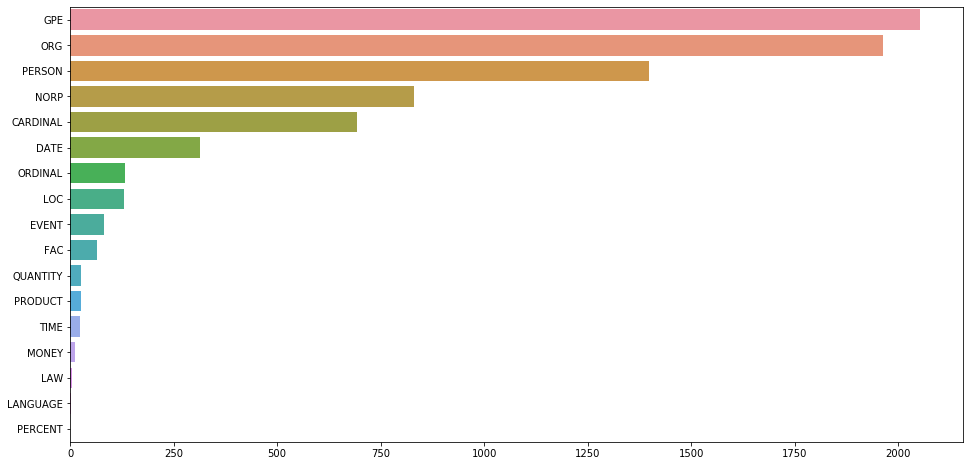

In [194]:
x,y = map(list,zip(*count))
sns.barplot(x=y, y=x)

#### We can also visualize the most common tokens per entity

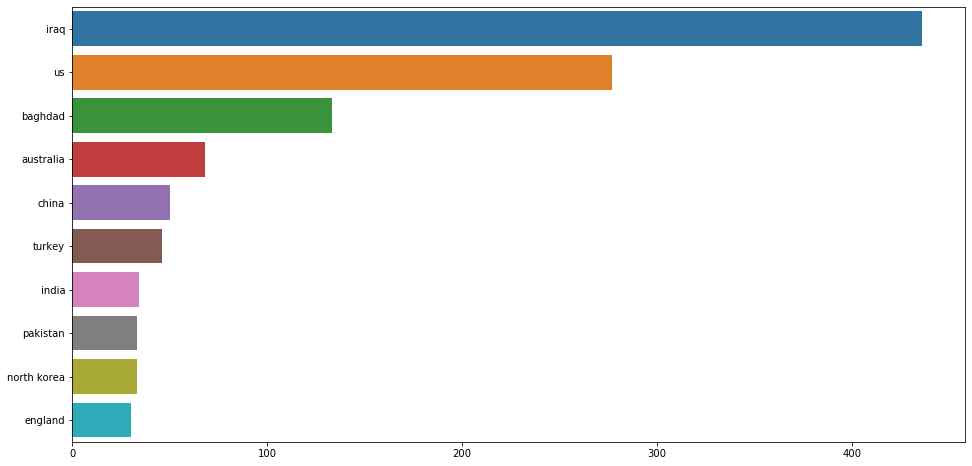

In [195]:
def ner(text,ent = "GPE"):
    doc = nlp(text)
    return [X.text for X in doc.ents if X.label_ == ent]

gpe = news['headline_text'].apply(lambda x: ner(x))
gpe = [i for x in gpe for i in x]
counter = Counter(gpe)

x,y = map(list,zip(*counter.most_common(10)))
sns.barplot(y,x)

#### Most common names on News headlines

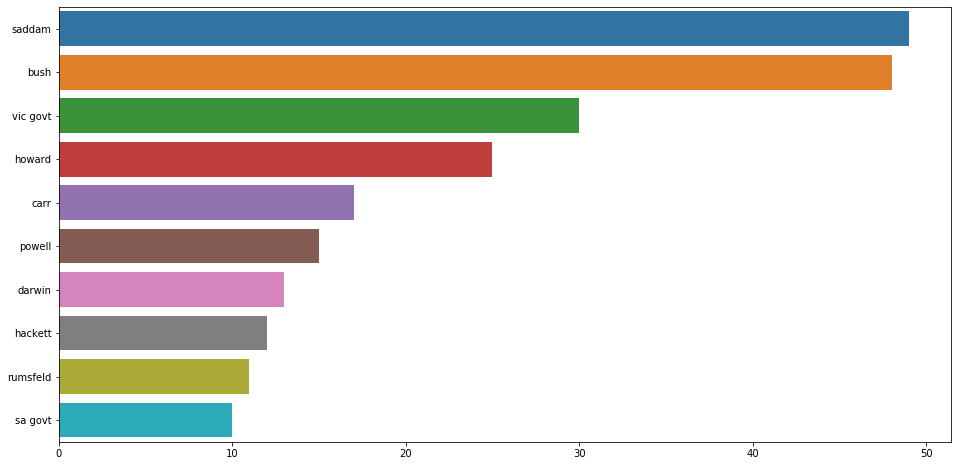

In [196]:
per = news['headline_text'].apply(lambda x: ner(x,"PERSON"))
per = [i for x in per for i in x]
counter = Counter(per)

x,y = map(list,zip(*counter.most_common(10)))
sns.barplot(y,x)

#### Exploration through Parts of Speach Tagging in python

In [197]:
import nltk
sentence = "The greatest comeback stories in 2019"
tokens = nltk.tokenize.word_tokenize(sentence)
nltk.pos_tag(tokens)

[('The', 'DT'),
 ('greatest', 'JJS'),
 ('comeback', 'NN'),
 ('stories', 'NNS'),
 ('in', 'IN'),
 ('2019', 'CD')]

In [198]:
doc = nlp('The greatest comeback stories in 2019')
displacy.render(doc, style='dep', jupyter=True, options={'distance': 90})

#### Now that we now what POS tagging is, let’s use it to explore our headlines dataset

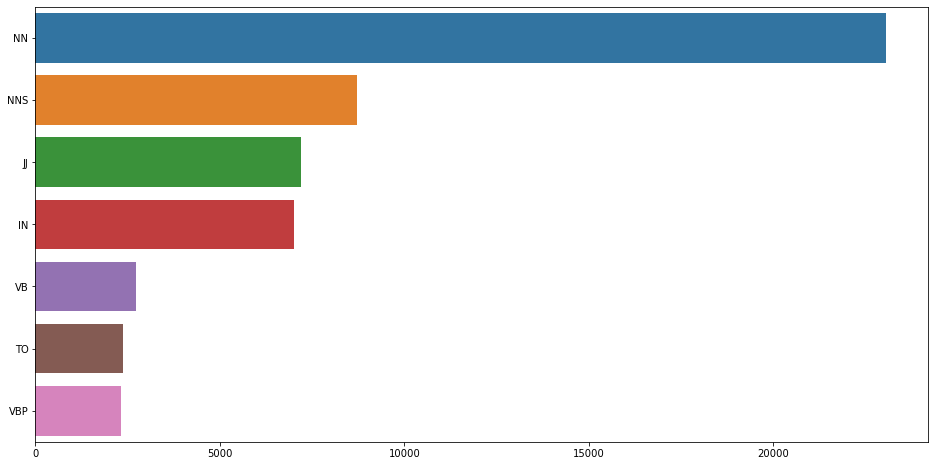

In [199]:
def pos(text):
    pos = nltk.pos_tag(nltk.tokenize.word_tokenize(text))
    pos = list(map(list,zip(*pos)))[1]
    return pos

tags = news['headline_text'].apply(lambda x : pos(x))
tags = [x for l in tags for x in l]
counter = Counter(tags)

x,y = list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y,y=x)

#### We can dig deeper into this by investigating which singular noun occur most commonly in news headlines

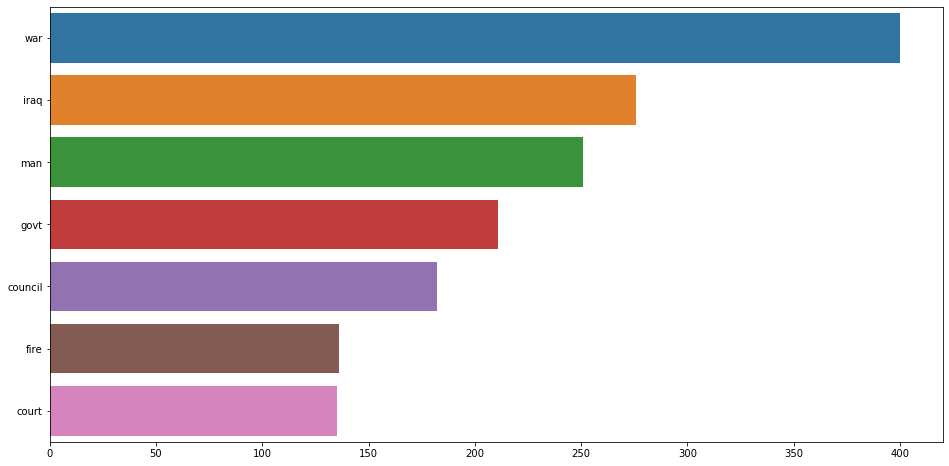

In [200]:
def get_adjs(text):
    adj = []
    pos = nltk.pos_tag(nltk.tokenize.word_tokenize(text))
    for word,tag in pos:
        if tag == 'NN':
            adj.append(word)
    return adj


words = news['headline_text'].apply(lambda x : get_adjs(x))
words = [x for l in words for x in l]
counter = Counter(words)

x,y = list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y,y=x)

#### Exploring through text complexity  

Readability index is a numeric value that indicates how difficult (or easy) it is to read and understand a text.  

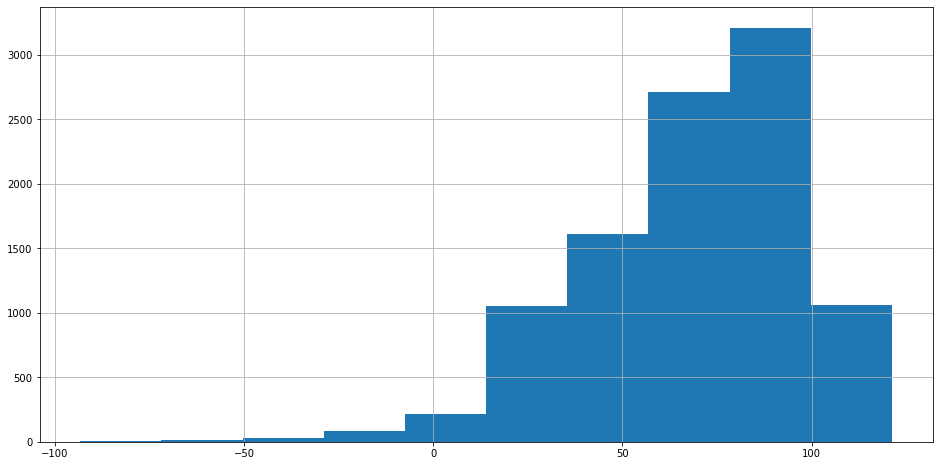

In [201]:
from textstat import flesch_reading_ease

news['headline_text'].apply(lambda x : flesch_reading_ease(x)).hist()

Almost all of the readability scores fall above 60. This means that an average 11-year-old student can read and understand the news headlines. Let’s check all news headlines that have a readability score below 5  

In [202]:
news['reading'] = news['headline_text'].apply(lambda x : flesch_reading_ease(x))
x = [i for i in range(len(news['reading'])) if news['reading'].iloc[i] < 5]
news.iloc[x]['headline_text'].head()

134    policewomen accusations feature at federal crime
150      report highlights container terminal potential
285       groups praise outgoing opposition agriculture
298            investigations underway into qantas skid
308      landholder contribution still under discussion
Name: headline_text, dtype: object